In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [03:09<00:00, 24.5MB/s]
100% 4.16G/4.16G [03:09<00:00, 23.6MB/s]


In [4]:
!unzip -qq /content/brats20-dataset-training-validation.zip

In [5]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.5 MB/s eta 0:00:00


In [6]:
import os
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from skimage.transform import rotate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow as tf



In [7]:

TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# renaming the file
try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")



File has been re-named successfully!


In [8]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [9]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1854.603271484375


In [10]:
# 자세한 과정은 chatGPT
scaler = MinMaxScaler()

test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [11]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [12]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

Slice Number: 95


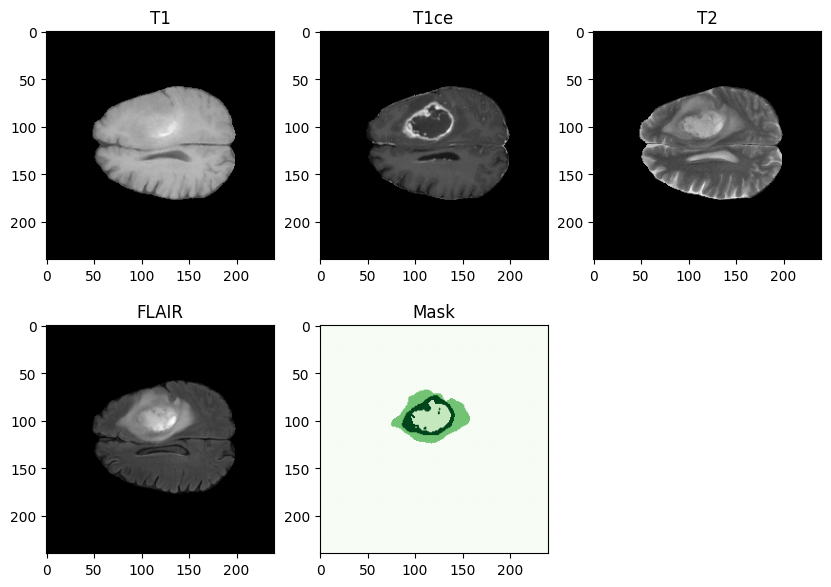

In [13]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(10, 7))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice], cmap='Greens')
plt.title('Mask')
plt.show()

In [14]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

# (width, height, slice)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


Slice number: 95


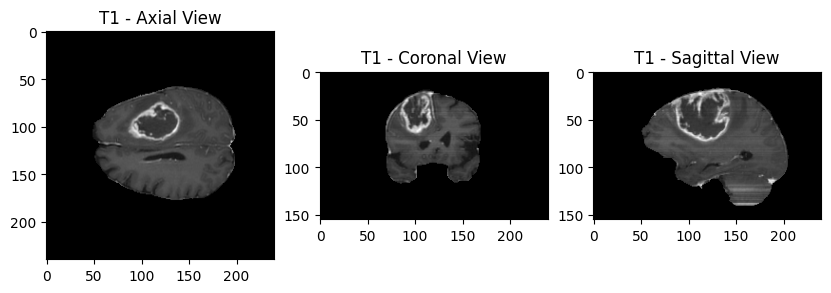

In [15]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(10, 6))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Axial View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Coronal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

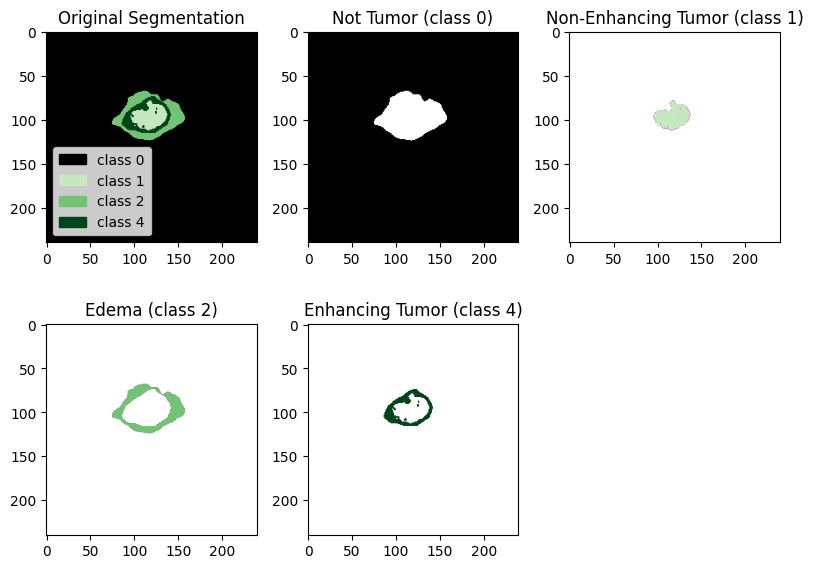

In [16]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#000000', '#C6E8BF', '#73C375', '#00441B'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(2, 3, figsize=(8, 6))

ax[0, 0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0, 0].set_title('Original Segmentation')
ax[0, 0].legend(handles=legend, loc='lower left')

ax[0, 1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[0, 1].set_title('Not Tumor (class 0)')

ax[0, 2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[0, 2].set_title('Non-Enhancing Tumor (class 1)')

ax[1, 0].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[1, 0].set_title('Edema (class 2)')

ax[1, 1].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[1, 1].set_title('Enhancing Tumor (class 4)')

ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [17]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.1, random_state=123)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.07, random_state=123)



In [18]:
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 308
Validation length: 37
Test length: 24


In [19]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 96
VOLUME_START_AT = 25 # first slice of volume that we will include
IMG_SIZE=128

In [113]:
rand_affine = RandAffined(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,
    spatial_size=(96, 128, 128),
    translate_range=(10, 20, 20),
    rotate_range=(np.pi / 72, np.pi / 72, np.pi / 8),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode="border",
)


class UnetrDataset(keras.utils.Sequence):
    def __init__(self, list_IDs, transform=False, dim=(IMG_SIZE,IMG_SIZE), n_channels = 2, shuffle=True):
        self.dim = dim
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = transform

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        id = self.list_IDs[index]

        X = np.zeros((VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((VOLUME_SLICES, 240, 240))
        Y = np.zeros((VOLUME_SLICES, *self.dim, 4))

        case_path = os.path.join(TRAIN_DATASET_PATH, id)

        data_path = os.path.join(case_path, f'{id}_flair.nii');
        flair = nib.load(data_path).get_fdata()

        data_path = os.path.join(case_path, f'{id}_t1ce.nii');
        t1ce = nib.load(data_path).get_fdata()

        data_path = os.path.join(case_path, f'{id}_seg.nii');
        seg = nib.load(data_path).get_fdata()

        for j in range(VOLUME_SLICES):
          X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
          X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

          y[j] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        # mask: (VOLUME_SLICES, 240, 240, 4)
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));


        # X: (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2)
        # Y: (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4)
        x, y = X/np.max(X), Y.numpy()

        if self.transform:
          rand_affine.set_random_state()
          x = np.transpose(x, (3, 0, 1, 2))  # (96, 128, 128, 2) -> (2, 96, 128, 128)
          y = np.transpose(y, (3, 0, 1, 2))  # (96, 128, 128, 4) -> (4, 96, 128, 128)
          data_dict = {"image": x, "label": y}
          affined_data_dict = rand_affine(data_dict)
          x, y = affined_data_dict["image"], affined_data_dict["label"]
          x = np.transpose(x, (1, 2, 3, 0))  # (2, 96, 128, 128) -> (96, 128, 128, 2)
          y = np.transpose(y, (1, 2, 3, 0))  # (4, 96, 128, 128) -> (96, 128, 128, 4)

        return x, y



training_generator = UnetrDataset(list_IDs=train_ids, transform=True)
valid_generator = UnetrDataset(list_IDs=val_ids)
test_generator = UnetrDataset(list_IDs=test_ids)

(2, 96, 128, 128)
(4, 96, 128, 128)
image shape: torch.Size([2, 96, 128, 128])
label shape: torch.Size([4, 96, 128, 128])


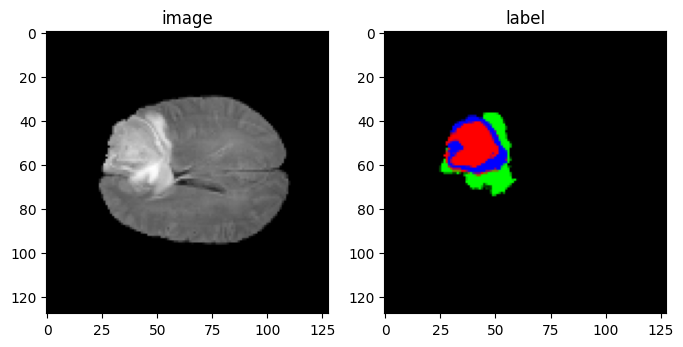

In [123]:
import torch

from monai.transforms import (
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    Orientationd,
    Rand3DElasticd,
    RandAffined,
    Spacingd,
)
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

rand_affine = RandAffined(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=0.5,
    spatial_size=(96, 128, 128),
    translate_range=(10, 20, 20),
    rotate_range=(np.pi / 72, np.pi / 72, np.pi / 72),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode="border",
)
rand_affine.set_random_state()

X_batch, Y_batch = training_generator[10]

X_batch = np.transpose(X_batch, (3, 0, 1, 2))  # (96, 128, 128, 2) -> (2, 96, 128, 128)
Y_batch = np.transpose(Y_batch, (3, 0, 1, 2))  # (96, 128, 128, 4) -> (4, 96, 128, 128)

print(X_batch.shape)
print(Y_batch.shape)
data_dict = {"image": X_batch, "label": Y_batch}

affined_data_dict = rand_affine(data_dict)
print(f"image shape: {affined_data_dict['image'].shape}")
print(f"label shape: {affined_data_dict['label'].shape}")


image, label = affined_data_dict["image"], affined_data_dict["label"]
image = np.transpose(image, (1, 2, 3, 0))  # (2, 96, 128, 128) -> (96, 128, 128, 2)
label = np.transpose(label, (1, 2, 3, 0))  # (4, 96, 128, 128) -> (96, 128, 128, 4)

plt.figure("visualise", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[60, :, :, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[60, :, :, 1:4])
plt.show()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(96, 128, 128, 2)
(96, 128, 128, 4)
(96, 128, 128)
(96, 128, 128)
(96, 128, 128)
torch.Size([2, 128, 128, 96])


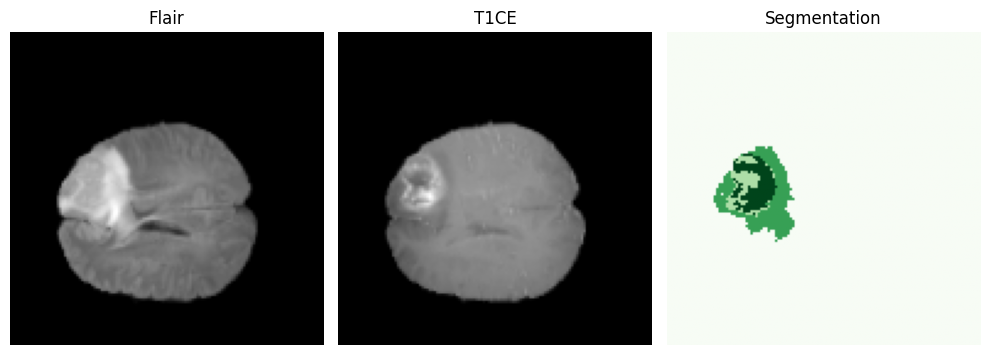

In [69]:
import torch
from torch import nn
from torch.utils.data import DataLoader

# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation, cmap='Greens') # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[10]

print(type(X_batch))
print(type(Y_batch))

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]

print(X_batch.shape) # (100, 128, 128, 2)
print(Y_batch.shape) # (100, 128, 128, 4)

segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

print(flair_batch.shape) # (100, 128, 128)
print(t1ce_batch.shape) # (100, 128, 128)
print(segmentation_batch.shape) # (100, 128, 128)

print(torch.from_numpy(X_batch).permute(3, 1, 2, 0).shape)

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 50  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

In [ ]:
"""
from torch.utils.data import DataLoader
from tqdm import tqdm


train_loader = DataLoader(
    dataset=training_generator,
    batch_size=1,
    pin_memory=False,
    shuffle=False,
    drop_last=False,
)

cnt = 0
loop = tqdm(train_loader, leave=True)

for batch_idx, (x, y) in enumerate(loop):

  print(x.shape)
  print(y.shape)
  cnt+=1
  if cnt == 1:
    break

# Y.numpy() 하니까 드디어 해결"""

'\nfrom torch.utils.data import DataLoader\nfrom tqdm import tqdm\n\n\ntrain_loader = DataLoader(\n    dataset=training_generator,\n    batch_size=1,\n    pin_memory=False,\n    shuffle=False,\n    drop_last=False,\n)\n\ncnt = 0\nloop = tqdm(train_loader, leave=True)\n\nfor batch_idx, (x, y) in enumerate(loop):\n\n  print(x.shape)\n  print(y.shape)\n  cnt+=1\n  if cnt == 1:\n    break\n\n# Y.numpy() 하니까 드디어 해결'

In [ ]:
"""
train_loader = DataLoader(
    dataset=training_generator,
    batch_size=1,
    shuffle=False,
    drop_last=False,
)
x, y = next(iter(train_loader))

print(x.shape)
print(y.shape)"""

'\ntrain_loader = DataLoader(\n    dataset=training_generator,\n    batch_size=1,\n    shuffle=False,\n    drop_last=False,\n)\nx, y = next(iter(train_loader))\n\nprint(x.shape)\nprint(y.shape)'

In [ ]:
"""
x = x.permute(0, 4, 2, 3, 1).float()
print(x.shape)"""

'\nx = x.permute(0, 4, 2, 3, 1).float()\nprint(x.shape)'

In [70]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from torch import Tensor

class Embeddings(nn.Module):
    def __init__(self, input_shape, patch_size=16, embed_dim=768, dropout=0.):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = input_shape[-4]
        self.n_patches = int((input_shape[-1] * input_shape[-2] * input_shape[-3]) / (patch_size * patch_size * patch_size))
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=self.in_channels, out_channels=self.embed_dim,
                                          kernel_size=self.patch_size, stride=self.patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, self.embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = rearrange(x, "b n h w d -> b (h w d) n")
        # batch, embed_dim, height/patch, width/patch, depth/patch
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


In [71]:
"""
E = Embeddings(x.shape[1:]) # -> torch.Size([2, 1176, 768])
summary(E, x.shape[1:], device='cpu')

embedding_x = E(x)
print(embedding_x.shape)"""

"\nE = Embeddings(x.shape[1:]) # -> torch.Size([2, 1176, 768])\nsummary(E, x.shape[1:], device='cpu')\n\nembedding_x = E(x)\nprint(embedding_x.shape)"

In [72]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self, d_model: int = 768, n_head: int = 8, dropout: float = 0.1):
    super().__init__()
    self.d_model = d_model
    self.n_head = n_head
    assert d_model % n_head == 0, "d_model is not divisible by n_head"
    self.d_k = d_model // n_head

    self.query = nn.Linear(d_model, d_model, bias=False)
    self.key = nn.Linear(d_model, d_model, bias=False)
    self.value = nn.Linear(d_model, d_model, bias=False)

    self.scale = math.sqrt(self.d_k)

    self.dense = nn.Linear(d_model, d_model, bias=False)
    self.dropout = nn.Dropout(dropout)

  def scaled_dot_product_attention(self, query, key, value, mask):
    # (Seq_len, d_k) -> (Seq_len, Seq_len)

    matmul_qk = query @ key.transpose(-2, -1)

    scaled_attention_logits = matmul_qk / self.scale

    if mask is not None:
      scaled_attention_logits.masked_fill_(mask == 0, -1e9) # if mask == 0 fill it as -1e9 (sim -inf)

    attention_score = scaled_attention_logits.softmax(dim=-1)
    attention_weights = self.dropout(attention_score)
    x = attention_weights @ value

    return x, attention_score

  def split_heads(self, x, n_head, d_k):
    # (Batch, Seq_len, d_model) -> (Batch, Seq_len, n_head, d_k) -> (Batch, n_head, Seq_len, d_k)
    x = x.view(x.shape[0], x.shape[1], n_head, d_k).transpose(1, 2)
    return x

  def forward(self, query, key, value, mask):
    Q = self.query(query) # (Seq_len, d_model) -> (Seq_len, d_model)
    K = self.key(key) # (Seq_len, d_model) -> (Seq_len, d_model)
    V = self.value(value) # (Seq_len, d_model) -> (Seq_len, d_model)

    Q = self.split_heads(Q, self.n_head, self.d_k)
    K = self.split_heads(K, self.n_head, self.d_k)
    V = self.split_heads(V, self.n_head, self.d_k)

    x, attention_score = self.scaled_dot_product_attention(Q, K, V, mask)

    # (Batch, n_head, Seq_len, d_k) -> (Batch, Seq_len, n_head, d_k) -> (Batch, Seq_len, d_model)
    concat_attention  = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.n_head * self.d_k)

    # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)
    return self.dense(concat_attention), attention_score

In [73]:
"""
mha = MultiHeadAttentionBlock()

mha_x = mha(embedding_x, embedding_x, embedding_x, None)

mha_x[0].shape"""

'\nmha = MultiHeadAttentionBlock()\n\nmha_x = mha(embedding_x, embedding_x, embedding_x, None)\n\nmha_x[0].shape'

In [74]:
class FeedForwardBlock(nn.Module):
  def __init__(self, d_model: int = 768, dropout: float = 0.1):
    super().__init__()
    self.ff_1 = nn.Linear(d_model, d_model * 4) # w1 and b1
    self.relu = nn.GELU()
    self.dropout = nn.Dropout(dropout)
    self.ff_2 = nn.Linear(d_model * 4, d_model) # w2 and b2

  def forward(self, x):
    x = self.ff_2(self.dropout(self.relu(self.ff_1(x))))
    return x


In [ ]:
"""
FF = FeedForwardBlock()
summary(FF, mha_x[0].shape[1:], device='cpu')

ff_x = FF(mha_x[0])
print(ff_x.shape)"""

"\nFF = FeedForwardBlock()\nsummary(FF, mha_x[0].shape[1:], device='cpu')\n\nff_x = FF(mha_x[0])\nprint(ff_x.shape)"

In [75]:
class EncoderBlock(nn.Module):
  def __init__(self, d_model: int = 768, n_head: int = 8, dropout: float = 0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(d_model)
    self.self_attention = MultiHeadAttentionBlock(d_model, n_head, dropout)
    self.feed_forward = FeedForwardBlock(d_model, dropout)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    res = x
    x = self.layer_norm(x)
    x, attention_score = self.self_attention(x, x, x, None)
    x = res + self.dropout(x)

    res = x
    x = self.layer_norm(x)
    x = self.feed_forward(x)
    x = res + self.dropout(x)

    return x


class VisionTransformer(nn.Module):
  def __init__(self, d_model: int = 768, n_head: int = 8, depth: int = 12, dropout: float = 0.1, extract: list = [3,6,9,12]):
    super().__init__()

    self.ViT = nn.ModuleList([EncoderBlock(d_model, n_head, dropout) for _ in range(depth)])
    self.extract = extract

  def forward(self, x):
    Z_layer = []

    for i, layer in enumerate(self.ViT):
      x = layer(x)
      if i+1 in self.extract:
        Z_layer.append(x)

    return Z_layer





In [76]:
"""
ViT = VisionTransformer()
#summary(ViT, embedding_x.shape[1:], device='cpu')

#for i in ViT(embedding_x):
#  print(i.shape)

z3, z6, z9, z12 = ViT(embedding_x)

print(z3.shape)
print(z6.shape)
print(z9.shape)
print(z12.shape)
"""

"\nViT = VisionTransformer()\n#summary(ViT, embedding_x.shape[1:], device='cpu')\n\n#for i in ViT(embedding_x):\n#  print(i.shape)\n\nz3, z6, z9, z12 = ViT(embedding_x)\n\nprint(z3.shape)\nprint(z6.shape)\nprint(z9.shape)\nprint(z12.shape)\n"

In [77]:
class Upsample3DBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.upsample = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

  def forward(self, x):
    return self.upsample(x)

class Conv3dBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, act=True):
    super().__init__()
    self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, stride=1, padding=((kernel_size - 1) // 2))
    self.act = act
    self.batch_norm = nn.BatchNorm3d(out_channels)
    self.relu = nn.ReLU(True)

  def forward(self, x):
    if self.act:
      return self.relu(self.batch_norm(self.conv3d(x)))
    else:
      return self.conv3d(x)

class Deconv3dBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.deconv3d = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv3d = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=((kernel_size - 1) // 2))
    self.batch_norm = nn.BatchNorm3d(out_channels)
    self.relu = nn.ReLU(True)

  def forward(self, x):
    return self.relu(self.batch_norm(self.conv3d(self.deconv3d(x))))



In [78]:
# reference: https://www.kaggle.com/code/usharengaraju/tensorflow-unetr-w-b
# reference: https://kimbg.tistory.com/33

class UNETR(nn.Module):
  def __init__(self, img_shape=(128, 128, 96), patch_size=16, in_channels=2,
               out_channels=4, d_model=768, n_head=8, dropout=0.1, light_r=4):
    super().__init__()

    self.img_shape = img_shape
    self.patch_size = patch_size
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.d_model = d_model
    self.n_head = n_head
    self.dropout = dropout
    self.patch_dim = [int(x / patch_size) for x in img_shape]
    self.conv_channels = [int(i/light_r) for i in [32, 64, 128, 256, 512, 1024]]

    self.embedding = Embeddings((in_channels, *img_shape))

    # U-net encoder
    self.encoder = VisionTransformer()

    # U-net decoder
    self.decoder0 = nn.Sequential(
        Conv3dBlock(in_channels, self.conv_channels[0], 3),
        Conv3dBlock(self.conv_channels[0], self.conv_channels[1], 3)
    )

    self.decoder3 = nn.Sequential(
        Deconv3dBlock(d_model, self.conv_channels[2], 3),
        Deconv3dBlock(self.conv_channels[2], self.conv_channels[2], 3),
        Deconv3dBlock(self.conv_channels[2], self.conv_channels[2], 3)
    )

    self.decoder6 = nn.Sequential(
        Deconv3dBlock(d_model, self.conv_channels[3], 3),
        Deconv3dBlock(self.conv_channels[3], self.conv_channels[3], 3)
    )

    self.decoder9 = nn.Sequential(
        Deconv3dBlock(d_model, self.conv_channels[4], 3)
    )

    self.decoder12_upsampler = Upsample3DBlock(d_model, self.conv_channels[4])

    self.decoder9_upsampler = nn.Sequential(
        Conv3dBlock(self.conv_channels[5], self.conv_channels[3], 3),
        Conv3dBlock(self.conv_channels[3], self.conv_channels[3], 3),
        Conv3dBlock(self.conv_channels[3], self.conv_channels[3], 3),
        Upsample3DBlock(self.conv_channels[3], self.conv_channels[3])
    )

    self.decoder6_upsampler = nn.Sequential(
        Conv3dBlock(self.conv_channels[4], self.conv_channels[2], 3),
        Conv3dBlock(self.conv_channels[2], self.conv_channels[2], 3),
        Upsample3DBlock(self.conv_channels[2], self.conv_channels[2])
    )

    self.decoder3_upsampler = nn.Sequential(
        Conv3dBlock(self.conv_channels[3], self.conv_channels[1], 3),
        Conv3dBlock(self.conv_channels[1], self.conv_channels[1], 3),
        Upsample3DBlock(self.conv_channels[1], self.conv_channels[1])
    )

    self.decoder0_header = nn.Sequential(
        Conv3dBlock(self.conv_channels[2], self.conv_channels[1], 3),
        Conv3dBlock(self.conv_channels[1], self.conv_channels[1], 3),
        Conv3dBlock(self.conv_channels[1], out_channels, 1, act=False)
    )

  def forward(self, x):
    z0 = x

    # x = (1, 1176, 768)
    x = self.embedding(x)

    # z = (1, 1176, 768)
    z3, z6, z9, z12 = self.encoder(x)

    # z = (1, 768, 14, 14, 6)
    z3 = z3.transpose(-1, -2).view(-1, self.d_model, *self.patch_dim)
    z6 = z6.transpose(-1, -2).view(-1, self.d_model, *self.patch_dim)
    z9 = z9.transpose(-1, -2).view(-1, self.d_model, *self.patch_dim)
    z12 = z12.transpose(-1, -2).view(-1, self.d_model, *self.patch_dim)

    z12 = self.decoder12_upsampler(z12)
    z9 = self.decoder9(z9)
    z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
    z6 = self.decoder6(z6)
    z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
    z3 = self.decoder3(z3)
    z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
    z0 = self.decoder0(z0)
    output = self.decoder0_header(torch.cat([z0, z3], dim=1))

    return output


In [79]:
"""
unetr = UNETR()
pred = unetr(x)
print(pred.shape)"""

'\nunetr = UNETR()\npred = unetr(x)\nprint(pred.shape)'

In [80]:
"""

import torch.nn as nn

def DiceLoss(pred, target):
  # bce = nn.BCEWithLogitsLoss(reduction='mean')
  # bce_loss = bce(pred, target)

  smooth = 1e-5
  pred = torch.sigmoid(pred)
  target = target.float()

  intersection = (pred * target).sum(dim=(2, 3, 4)) # H W D
  union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))

  dice = (2. * intersection + smooth) / (union + smooth)
  dice_loss = 1 - dice

  return dice_loss.mean()

def DiceScore(pred, target):
  smooth = 1e-5
  pred = torch.sigmoid(pred)
  pred = (pred > 0.5).float()
  target = target.float()

  intersection = (pred * target).sum(dim=(2, 3, 4)) # H W D
  union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))

  dice = (2. * intersection + smooth) / (union + smooth)

  return dice.mean()

"""


"\n\nimport torch.nn as nn\n\ndef DiceLoss(pred, target):\n  # bce = nn.BCEWithLogitsLoss(reduction='mean')\n  # bce_loss = bce(pred, target)\n\n  smooth = 1e-5\n  pred = torch.sigmoid(pred)\n  target = target.float()\n\n  intersection = (pred * target).sum(dim=(2, 3, 4)) # H W D\n  union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))\n\n  dice = (2. * intersection + smooth) / (union + smooth)\n  dice_loss = 1 - dice\n\n  return dice_loss.mean()\n\ndef DiceScore(pred, target):\n  smooth = 1e-5\n  pred = torch.sigmoid(pred)\n  pred = (pred > 0.5).float()\n  target = target.float()\n\n  intersection = (pred * target).sum(dim=(2, 3, 4)) # H W D\n  union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))\n\n  dice = (2. * intersection + smooth) / (union + smooth)\n\n  return dice.mean()\n\n"

In [81]:
# dice_loss = DiceLoss(pred, y)
# dice_score = DiceScore(pred, y)

# print(dice_loss)
# print(dice_score)

In [82]:
import monai
from monai.losses import DiceCELoss, DiceLoss

torch.backends.cudnn.benchmark = True

LossFuncion = monai.losses.DiceLoss(include_background=True, to_onehot_y=False, softmax=True)
MetricDice = monai.metrics.DiceMetric(include_background=True, reduction="mean")


def BinaryOutput(output, keepdim=True):
    shape = output.shape
    argmax_idx = torch.argmax(output, axis=1, keepdim=True)
    argmax_oh = F.one_hot(argmax_idx, num_classes=4)
    if keepdim:
        argmax_oh = torch.squeeze(argmax_oh, dim=1)
    if len(shape) == 5:
        argmax_oh = argmax_oh.permute(0,4,1,2,3)
    elif len(shape) == 4:
        argmax_oh = argmax_oh.permute(0,3,1,2)

    return argmax_oh

In [124]:
from torch.utils.data import DataLoader

training_generator = UnetrDataset(train_ids)
valid_generator = UnetrDataset(val_ids)
test_generator = UnetrDataset(test_ids)

train_loader = DataLoader(
    dataset=training_generator,
    batch_size=4,
    num_workers=0,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)

valid_loader = DataLoader(
    dataset=valid_generator,
    batch_size=1,
    num_workers=0,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_generator,
    batch_size=1,
    num_workers=0,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
)

In [84]:
"""
x, y = next(iter(train_loader))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = UNETR().to(DEVICE)

x = x.permute(0, 4, 2, 3, 1).float()
y = y.permute(0, 4, 2, 3, 1).float()
x = x.to(DEVICE)
y = y.to(DEVICE)
pred = model(x)
loss = LossFuncion(pred, y)

print(loss)"""



'\nx, y = next(iter(train_loader))\nDEVICE = "cuda" if torch.cuda.is_available() else "cpu"\n\nmodel = UNETR().to(DEVICE)\n\nx = x.permute(0, 4, 2, 3, 1).float()\ny = y.permute(0, 4, 2, 3, 1).float()\nx = x.to(DEVICE)\ny = y.to(DEVICE)\npred = model(x)\nloss = LossFuncion(pred, y)\n\nprint(loss)'

In [86]:
from tqdm import tqdm
from monai.losses.dice import DiceLoss, one_hot
from torch.optim.lr_scheduler import CosineAnnealingLR
# batch size, img size, light_r 적정값 찾아야 함

def train(model, optimizer, train_loader, DEVICE):
  model.train()
  batch_loss = []
  epoch_loss = 0
  epoch_dice_scores = 0

  loop = tqdm(train_loader, leave=True)

  for batch_idx, (x, y) in enumerate(loop):

    x = x.permute(0, 4, 2, 3, 1).float()
    y = y.permute(0, 4, 2, 3, 1).float()
    # y = np.argmax(y, axis=1)
    # y = one_hot(y[:, None, ...], num_classes=4)
    x = x.to(DEVICE)
    y = y.to(DEVICE)

    pred = model(x)

    loss = LossFuncion(pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss.item()

    bi_output = BinaryOutput(pred)
    MetricDice(bi_output, y)
    dice_score = MetricDice.aggregate().item()
    epoch_dice_scores += dice_score


    batch_loss.append(loss.item())
    mean_loss = sum(batch_loss) / len(batch_loss)
    loop.set_postfix(loss=mean_loss)

  avg_loss = epoch_loss / len(train_loader)
  avg_dice_score = epoch_dice_scores / len(train_loader)

  return avg_loss, avg_dice_score


def eval(model, optimizer, valid_loader, DEVICE):
  model.eval()
  epoch_loss = 0
  epoch_dice_scores = 0

  loop = tqdm(valid_loader, leave=True)

  with torch.no_grad():
    for batch_idx, (x, y) in enumerate(loop):

      x = x.permute(0, 4, 2, 3, 1).float()
      y = y.permute(0, 4, 2, 3, 1).float()
      x = x.to(DEVICE)
      y = y.to(DEVICE)

      pred = model(x)

      loss = LossFuncion(pred, y)
      epoch_loss += loss.item()

      bi_output = BinaryOutput(pred)
      MetricDice(bi_output, y)
      dice_score = MetricDice.aggregate().item()
      epoch_dice_scores += dice_score

  avg_loss = epoch_loss / len(train_loader)
  avg_dice_score = epoch_dice_scores / len(train_loader)

  MetricDice.reset()

  return avg_loss, avg_dice_score


def func(epoch):
    if epoch < 50:
        return 1     # 0.0001
    elif epoch < 100:
        return 0.5   # 0.00005
    else:
        return 0.2   # 0.00001

EPOCHS = 200
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_SAVE = True
model = UNETR().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=210)
best_loss = 999
best_epoch = -1
torch.backends.cudnn.benchmark = True

def save_checkpoint(model, optimizer, filename):
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer": optimizer.state_dict(),
  }
  torch.save(checkpoint, filename)

for epoch in range(1, EPOCHS+1):
  print(scheduler._last_lr)
  train_avg_loss, train_avg_dice_score = train(model, optimizer, train_loader, DEVICE)
  print(f"Epoch: {epoch}/{EPOCHS}, Loss: {train_avg_loss:.4f}, Dice Score: {train_avg_dice_score:.4f}")
  scheduler.step()

  if epoch % 5 == 0 or epoch == 1:
    eval_avg_loss, eval_avg_dice_score = eval(model, optimizer, valid_loader, DEVICE)

  if eval_avg_loss < best_loss:
    best_loss = eval_avg_loss
    best_epoch = epoch
    print(f"Validation in Epoch: {epoch}/{EPOCHS}, Loss: {eval_avg_loss:.4f}, Dice Score: {eval_avg_dice_score:.4f}")

    if MODEL_SAVE:
      filename = '/content/drive/MyDrive/unetr/unter_weights.pth'
      save_checkpoint(model, optimizer, filename)




[0.0001]


100%|██████████| 77/77 [05:10<00:00,  4.03s/it, loss=0.872]


Epoch: 1/200, Loss: 0.8722, Dice Score: 0.1927


100%|██████████| 37/37 [00:31<00:00,  1.17it/s]


Validation in Epoch: 1/200, Loss: 0.4095, Dice Score: 0.1154
[9.999440509051368e-05]


100%|██████████| 77/77 [04:25<00:00,  3.45s/it, loss=0.854]


Epoch: 2/200, Loss: 0.8537, Dice Score: 0.2803
[9.997762161417517e-05]


100%|██████████| 77/77 [04:24<00:00,  3.43s/it, loss=0.842]


Epoch: 3/200, Loss: 0.8424, Dice Score: 0.2805
[9.994965332706575e-05]


100%|██████████| 77/77 [04:24<00:00,  3.43s/it, loss=0.832]


Epoch: 4/200, Loss: 0.8318, Dice Score: 0.2816
[9.991050648838676e-05]


100%|██████████| 77/77 [04:27<00:00,  3.48s/it, loss=0.824]


Epoch: 5/200, Loss: 0.8238, Dice Score: 0.2832


100%|██████████| 37/37 [00:22<00:00,  1.62it/s]


Validation in Epoch: 5/200, Loss: 0.4054, Dice Score: 0.1365
[9.986018985905901e-05]


100%|██████████| 77/77 [04:24<00:00,  3.44s/it, loss=0.817]


Epoch: 6/200, Loss: 0.8172, Dice Score: 0.2881
[9.979871469976197e-05]


100%|██████████| 77/77 [04:25<00:00,  3.45s/it, loss=0.811]


Epoch: 7/200, Loss: 0.8109, Dice Score: 0.2850
[9.972609476841368e-05]


100%|██████████| 77/77 [04:23<00:00,  3.42s/it, loss=0.804]


Epoch: 8/200, Loss: 0.8042, Dice Score: 0.2848
[9.96423463170919e-05]


100%|██████████| 77/77 [04:26<00:00,  3.46s/it, loss=0.798]


Epoch: 9/200, Loss: 0.7981, Dice Score: 0.2847
[9.954748808839678e-05]


100%|██████████| 77/77 [04:26<00:00,  3.46s/it, loss=0.791]


Epoch: 10/200, Loss: 0.7915, Dice Score: 0.2867


100%|██████████| 37/37 [00:21<00:00,  1.71it/s]


Validation in Epoch: 10/200, Loss: 0.3801, Dice Score: 0.1384
[9.944154131125646e-05]


100%|██████████| 77/77 [04:24<00:00,  3.44s/it, loss=0.782]


Epoch: 11/200, Loss: 0.7818, Dice Score: 0.3006
[9.932452969617611e-05]


100%|██████████| 77/77 [04:20<00:00,  3.38s/it, loss=0.771]


Epoch: 12/200, Loss: 0.7710, Dice Score: 0.3032
[9.919647942993152e-05]


100%|██████████| 77/77 [04:25<00:00,  3.44s/it, loss=0.76]


Epoch: 13/200, Loss: 0.7605, Dice Score: 0.3069
[9.905741916970867e-05]


100%|██████████| 77/77 [04:22<00:00,  3.41s/it, loss=0.751]


Epoch: 14/200, Loss: 0.7513, Dice Score: 0.3080
[9.890738003669032e-05]


100%|██████████| 77/77 [04:23<00:00,  3.43s/it, loss=0.743]


Epoch: 15/200, Loss: 0.7427, Dice Score: 0.3092


100%|██████████| 37/37 [00:19<00:00,  1.87it/s]


Validation in Epoch: 15/200, Loss: 0.3509, Dice Score: 0.1491
[9.87463956090912e-05]


100%|██████████| 77/77 [04:25<00:00,  3.45s/it, loss=0.734]


Epoch: 16/200, Loss: 0.7337, Dice Score: 0.3136
[9.857450191464339e-05]


100%|██████████| 77/77 [04:24<00:00,  3.44s/it, loss=0.723]


Epoch: 17/200, Loss: 0.7231, Dice Score: 0.3469
[9.839173742253336e-05]


100%|██████████| 77/77 [04:24<00:00,  3.43s/it, loss=0.713]


Epoch: 18/200, Loss: 0.7134, Dice Score: 0.3755
[9.819814303479268e-05]


100%|██████████| 77/77 [04:25<00:00,  3.44s/it, loss=0.705]


Epoch: 19/200, Loss: 0.7046, Dice Score: 0.3934
[9.799376207714447e-05]


100%|██████████| 77/77 [04:24<00:00,  3.43s/it, loss=0.696]


Epoch: 20/200, Loss: 0.6960, Dice Score: 0.4041


100%|██████████| 37/37 [00:21<00:00,  1.76it/s]


Validation in Epoch: 20/200, Loss: 0.3418, Dice Score: 0.1970
[9.777864028930703e-05]


100%|██████████| 77/77 [04:25<00:00,  3.45s/it, loss=0.688]


Epoch: 21/200, Loss: 0.6885, Dice Score: 0.4601
[9.755282581475769e-05]


100%|██████████| 77/77 [04:20<00:00,  3.38s/it, loss=0.68]


Epoch: 22/200, Loss: 0.6799, Dice Score: 0.4564
[9.731636918995821e-05]


100%|██████████| 77/77 [04:21<00:00,  3.39s/it, loss=0.669]


Epoch: 23/200, Loss: 0.6695, Dice Score: 0.4622
[9.706932333304517e-05]


100%|██████████| 77/77 [04:22<00:00,  3.41s/it, loss=0.663]


Epoch: 24/200, Loss: 0.6631, Dice Score: 0.4654
[9.681174353198685e-05]


100%|██████████| 77/77 [04:22<00:00,  3.41s/it, loss=0.651]


Epoch: 25/200, Loss: 0.6506, Dice Score: 0.4700


100%|██████████| 37/37 [00:21<00:00,  1.72it/s]


Validation in Epoch: 25/200, Loss: 0.3181, Dice Score: 0.2269
[9.654368743221021e-05]


100%|██████████| 77/77 [04:20<00:00,  3.38s/it, loss=0.643]


Epoch: 26/200, Loss: 0.6426, Dice Score: 0.4980
[9.626521502369983e-05]


100%|██████████| 77/77 [04:21<00:00,  3.39s/it, loss=0.637]


Epoch: 27/200, Loss: 0.6366, Dice Score: 0.4940
[9.597638862757254e-05]


100%|██████████| 77/77 [04:20<00:00,  3.38s/it, loss=0.628]


Epoch: 28/200, Loss: 0.6278, Dice Score: 0.4960
[9.567727288213005e-05]


100%|██████████| 77/77 [04:22<00:00,  3.40s/it, loss=0.618]


Epoch: 29/200, Loss: 0.6181, Dice Score: 0.4959
[9.536793472839325e-05]


100%|██████████| 77/77 [04:22<00:00,  3.41s/it, loss=0.619]


Epoch: 30/200, Loss: 0.6190, Dice Score: 0.4975


100%|██████████| 37/37 [00:21<00:00,  1.75it/s]


Validation in Epoch: 30/200, Loss: 0.3001, Dice Score: 0.2389
[9.504844339512095e-05]


100%|██████████| 77/77 [04:22<00:00,  3.41s/it, loss=0.605]


Epoch: 31/200, Loss: 0.6051, Dice Score: 0.5105
[9.471887038331685e-05]


100%|██████████| 77/77 [04:21<00:00,  3.39s/it, loss=0.6]


Epoch: 32/200, Loss: 0.5997, Dice Score: 0.5034
[9.437928945022771e-05]


100%|██████████| 77/77 [04:21<00:00,  3.40s/it, loss=0.588]


Epoch: 33/200, Loss: 0.5881, Dice Score: 0.5076
[9.40297765928369e-05]


100%|██████████| 77/77 [04:22<00:00,  3.41s/it, loss=0.581]


Epoch: 34/200, Loss: 0.5809, Dice Score: 0.5123
[9.367041003085648e-05]


100%|██████████| 77/77 [04:21<00:00,  3.40s/it, loss=0.568]


Epoch: 35/200, Loss: 0.5684, Dice Score: 0.5198


100%|██████████| 37/37 [00:21<00:00,  1.74it/s]


Validation in Epoch: 35/200, Loss: 0.2731, Dice Score: 0.2519
[9.330127018922194e-05]


100%|██████████| 77/77 [04:19<00:00,  3.37s/it, loss=0.553]


Epoch: 36/200, Loss: 0.5534, Dice Score: 0.5759
[9.292243968009331e-05]


100%|██████████| 77/77 [04:20<00:00,  3.38s/it, loss=0.536]


Epoch: 37/200, Loss: 0.5361, Dice Score: 0.5784
[9.253400328436699e-05]


100%|██████████| 77/77 [04:12<00:00,  3.29s/it, loss=0.527]


Epoch: 38/200, Loss: 0.5267, Dice Score: 0.5826
[9.213604793270197e-05]


100%|██████████| 77/77 [04:04<00:00,  3.18s/it, loss=0.511]


Epoch: 39/200, Loss: 0.5108, Dice Score: 0.5869
[9.172866268606513e-05]


100%|██████████| 77/77 [04:04<00:00,  3.18s/it, loss=0.496]


Epoch: 40/200, Loss: 0.4957, Dice Score: 0.5899


100%|██████████| 37/37 [00:19<00:00,  1.87it/s]


Validation in Epoch: 40/200, Loss: 0.2492, Dice Score: 0.2841
[9.131193871579975e-05]


100%|██████████| 77/77 [04:04<00:00,  3.18s/it, loss=0.481]


Epoch: 41/200, Loss: 0.4815, Dice Score: 0.6024
[9.088596928322157e-05]


100%|██████████| 77/77 [04:01<00:00,  3.13s/it, loss=0.473]


Epoch: 42/200, Loss: 0.4735, Dice Score: 0.6160
[9.045084971874737e-05]


100%|██████████| 77/77 [04:00<00:00,  3.12s/it, loss=0.466]


Epoch: 43/200, Loss: 0.4664, Dice Score: 0.6150
[9.000667740056032e-05]


100%|██████████| 77/77 [04:00<00:00,  3.12s/it, loss=0.455]


Epoch: 44/200, Loss: 0.4552, Dice Score: 0.6150
[8.955355173281708e-05]


100%|██████████| 77/77 [04:05<00:00,  3.18s/it, loss=0.445]


Epoch: 45/200, Loss: 0.4450, Dice Score: 0.6178


100%|██████████| 37/37 [00:19<00:00,  1.93it/s]


Validation in Epoch: 45/200, Loss: 0.2326, Dice Score: 0.2966
[8.909157412340151e-05]


100%|██████████| 77/77 [04:11<00:00,  3.26s/it, loss=0.439]


Epoch: 46/200, Loss: 0.4392, Dice Score: 0.6340
[8.862084796122999e-05]


100%|██████████| 77/77 [04:10<00:00,  3.25s/it, loss=0.431]


Epoch: 47/200, Loss: 0.4310, Dice Score: 0.6271
[8.814147859311334e-05]


100%|██████████| 77/77 [04:10<00:00,  3.26s/it, loss=0.428]


Epoch: 48/200, Loss: 0.4278, Dice Score: 0.6275
[8.765357330018057e-05]


100%|██████████| 77/77 [04:12<00:00,  3.28s/it, loss=0.42]


Epoch: 49/200, Loss: 0.4202, Dice Score: 0.6285
[8.715724127386975e-05]


100%|██████████| 77/77 [04:12<00:00,  3.28s/it, loss=0.41]


Epoch: 50/200, Loss: 0.4098, Dice Score: 0.6324


100%|██████████| 37/37 [00:19<00:00,  1.85it/s]


Validation in Epoch: 50/200, Loss: 0.2162, Dice Score: 0.3037
[8.665259359149133e-05]


100%|██████████| 77/77 [04:13<00:00,  3.29s/it, loss=0.404]


Epoch: 51/200, Loss: 0.4044, Dice Score: 0.6324
[8.61397431913696e-05]


100%|██████████| 77/77 [04:11<00:00,  3.27s/it, loss=0.405]


Epoch: 52/200, Loss: 0.4055, Dice Score: 0.6452
[8.561880484756726e-05]


100%|██████████| 77/77 [04:12<00:00,  3.28s/it, loss=0.403]


Epoch: 53/200, Loss: 0.4028, Dice Score: 0.6447
[8.50898951441996e-05]


100%|██████████| 77/77 [04:16<00:00,  3.33s/it, loss=0.392]


Epoch: 54/200, Loss: 0.3922, Dice Score: 0.6469
[8.455313244934326e-05]


100%|██████████| 77/77 [04:16<00:00,  3.34s/it, loss=0.396]


Epoch: 55/200, Loss: 0.3961, Dice Score: 0.6465


100%|██████████| 37/37 [00:20<00:00,  1.80it/s]


Validation in Epoch: 55/200, Loss: 0.2091, Dice Score: 0.3103
[8.400863688854597e-05]


100%|██████████| 77/77 [04:23<00:00,  3.42s/it, loss=0.385]


Epoch: 56/200, Loss: 0.3851, Dice Score: 0.6540
[8.345653031794292e-05]


100%|██████████| 77/77 [04:21<00:00,  3.40s/it, loss=0.383]


Epoch: 57/200, Loss: 0.3831, Dice Score: 0.6557
[8.289693629698562e-05]


100%|██████████| 77/77 [04:21<00:00,  3.40s/it, loss=0.379]


Epoch: 58/200, Loss: 0.3792, Dice Score: 0.6559
[8.232998006078997e-05]


100%|██████████| 77/77 [04:20<00:00,  3.38s/it, loss=0.375]


Epoch: 59/200, Loss: 0.3754, Dice Score: 0.6576
[8.175578849210893e-05]


100%|██████████| 77/77 [04:22<00:00,  3.40s/it, loss=0.373]


Epoch: 60/200, Loss: 0.3730, Dice Score: 0.6598


100%|██████████| 37/37 [00:20<00:00,  1.79it/s]


Validation in Epoch: 60/200, Loss: 0.1954, Dice Score: 0.3166
[8.117449009293667e-05]


100%|██████████| 77/77 [04:20<00:00,  3.38s/it, loss=0.372]


Epoch: 61/200, Loss: 0.3723, Dice Score: 0.6742
[8.05862149557503e-05]


100%|██████████| 77/77 [04:23<00:00,  3.42s/it, loss=0.374]


Epoch: 62/200, Loss: 0.3744, Dice Score: 0.6626
[7.999109473439568e-05]


100%|██████████| 77/77 [04:21<00:00,  3.39s/it, loss=0.372]


Epoch: 63/200, Loss: 0.3722, Dice Score: 0.6608
[7.938926261462365e-05]


100%|██████████| 77/77 [04:21<00:00,  3.40s/it, loss=0.367]


Epoch: 64/200, Loss: 0.3672, Dice Score: 0.6618
[7.878085328428367e-05]


100%|██████████| 77/77 [04:21<00:00,  3.40s/it, loss=0.367]


Epoch: 65/200, Loss: 0.3666, Dice Score: 0.6624


100%|██████████| 37/37 [00:21<00:00,  1.70it/s]


Validation in Epoch: 65/200, Loss: 0.1909, Dice Score: 0.3181
[7.816600290318108e-05]


100%|██████████| 77/77 [04:20<00:00,  3.38s/it, loss=0.364]


Epoch: 66/200, Loss: 0.3639, Dice Score: 0.6691
[7.754484907260511e-05]


100%|██████████| 77/77 [04:21<00:00,  3.39s/it, loss=0.357]


Epoch: 67/200, Loss: 0.3566, Dice Score: 0.6720
[7.69175308045341e-05]


100%|██████████| 77/77 [04:19<00:00,  3.37s/it, loss=0.354]


Epoch: 68/200, Loss: 0.3539, Dice Score: 0.6712
[7.628418849052521e-05]


100%|██████████| 77/77 [04:20<00:00,  3.39s/it, loss=0.353]


Epoch: 69/200, Loss: 0.3525, Dice Score: 0.6728
[7.564496387029529e-05]


100%|██████████| 77/77 [04:21<00:00,  3.39s/it, loss=0.349]


Epoch: 70/200, Loss: 0.3492, Dice Score: 0.6743


100%|██████████| 37/37 [00:21<00:00,  1.74it/s]


Validation in Epoch: 70/200, Loss: 0.1832, Dice Score: 0.3240
[7.499999999999998e-05]


100%|██████████| 77/77 [04:18<00:00,  3.36s/it, loss=0.351]


Epoch: 71/200, Loss: 0.3508, Dice Score: 0.6669
[7.434944122021834e-05]


100%|██████████| 77/77 [04:21<00:00,  3.39s/it, loss=0.355]


Epoch: 72/200, Loss: 0.3552, Dice Score: 0.6777
[7.369343312364992e-05]


100%|██████████| 77/77 [04:24<00:00,  3.43s/it, loss=0.346]


Epoch: 73/200, Loss: 0.3460, Dice Score: 0.6760
[7.30321225225316e-05]


100%|██████████| 77/77 [04:23<00:00,  3.43s/it, loss=0.347]


Epoch: 74/200, Loss: 0.3470, Dice Score: 0.6793
[7.236565741578162e-05]


100%|██████████| 77/77 [04:22<00:00,  3.41s/it, loss=0.347]


Epoch: 75/200, Loss: 0.3472, Dice Score: 0.6787


100%|██████████| 37/37 [00:22<00:00,  1.67it/s]


Validation in Epoch: 75/200, Loss: 0.1818, Dice Score: 0.3258
[7.16941869558779e-05]


  1%|▏         | 1/77 [00:03<04:34,  3.61s/it, loss=0.346]


KeyboardInterrupt: 

In [125]:
SLICE = 60
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

def Display_Tumor_Segmenstation(model, x, y, DEVICE):
  model.eval()
  with torch.no_grad():
    input = x.permute(0, 4, 2, 3, 1).float() # (1, 4, 128, 128, 96)
    input = input.to(DEVICE)
    p = model(input).detach().cpu()
  # p = torch.sigmoid(p)
  p = p.squeeze(dim=0) # (4, 128, 128, 96)
  p = p.permute(3, 1, 2, 0).numpy() # (96, 128, 128, 4)
  # segmentation = torch.argmax(p, dim=-1)

  core = p[:,:,:,1]
  edema = p[:,:,:,2]
  enhancing = p[:,:,:,3]

  x = x.squeeze(dim=0).numpy() # (96, 128, 128, 4)
  y = y.squeeze(dim=0).numpy()


  gt = np.argmax(y, axis=-1)
  pred_all = np.argmax(p, axis=-1)
  pred_all = pred_all.astype(float)


  pred_zero = pred_all.copy()
  pred_zero[pred_zero != 0] = np.nan
  pred_core = pred_all.copy()
  pred_core[pred_core != 1] = np.nan
  pred_edema = pred_all.copy()
  pred_edema[pred_edema != 2] = np.nan
  pred_enhancing = pred_all.copy()
  pred_enhancing[pred_enhancing != 3] = np.nan




  plt.figure(figsize=(10, 10))
  f, axarr = plt.subplots(4,3, figsize = (9, 13))

  for i in range(2):
    for j in range(3):
      axarr[i][j].imshow(x[SLICE,:,:,0], cmap='gray', interpolation='none')

  axarr[0][0].imshow(x[SLICE,:,:,0], cmap='gray')
  axarr[0][0].title.set_text('Original image flair')
  curr_gt = cv2.resize(y[SLICE,:,:, 1:4], (128, 128), interpolation = cv2.INTER_NEAREST)
  axarr[0][1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.2)
  axarr[0][1].title.set_text('Ground truth')
  axarr[0][2].imshow(p[SLICE,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.2)
  axarr[0][2].title.set_text('all classes predicted')
  axarr[1][0].imshow(core[SLICE,:,:], cmap="OrRd", interpolation='none', alpha=0.2)
  axarr[1][0].title.set_text('Predicted - core')
  axarr[1][1].imshow(edema[SLICE,:,:], cmap="OrRd", interpolation='none', alpha=0.2)
  axarr[1][1].title.set_text('Predicted - edema')
  axarr[1][2].imshow(enhancing[SLICE,:,:], cmap="OrRd", interpolation='none', alpha=0.2)
  axarr[1][2].title.set_text('Predicted - enhancing')

  axarr[2][0].imshow(gt[SLICE,:,:], cmap, norm)
  axarr[2][0].title.set_text('Original Segmentation')
  axarr[2][1].imshow(pred_all[SLICE,:,:], cmap, norm)
  axarr[2][1].title.set_text('Predicted - all classes')
  axarr[2][2].imshow(pred_zero[SLICE,:,:], cmap, norm)
  axarr[2][2].title.set_text('Predicted - Not Tumor')
  axarr[3][0].imshow(pred_core[SLICE,:,:], cmap, norm)
  axarr[3][0].title.set_text('Predicted - Necrotic/Core')
  axarr[3][1].imshow(pred_edema[SLICE,:,:], cmap, norm)
  axarr[3][1].title.set_text('Predicted - Edema')
  axarr[3][2].imshow(pred_enhancing[SLICE,:,:], cmap, norm)
  axarr[3][2].title.set_text('Predicted - Enhancing')

  plt.show()


<ipython-input-128-4fa933fb6f52>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_filename, map_location=DEVICE)


<Figure size 1000x1000 with 0 Axes>

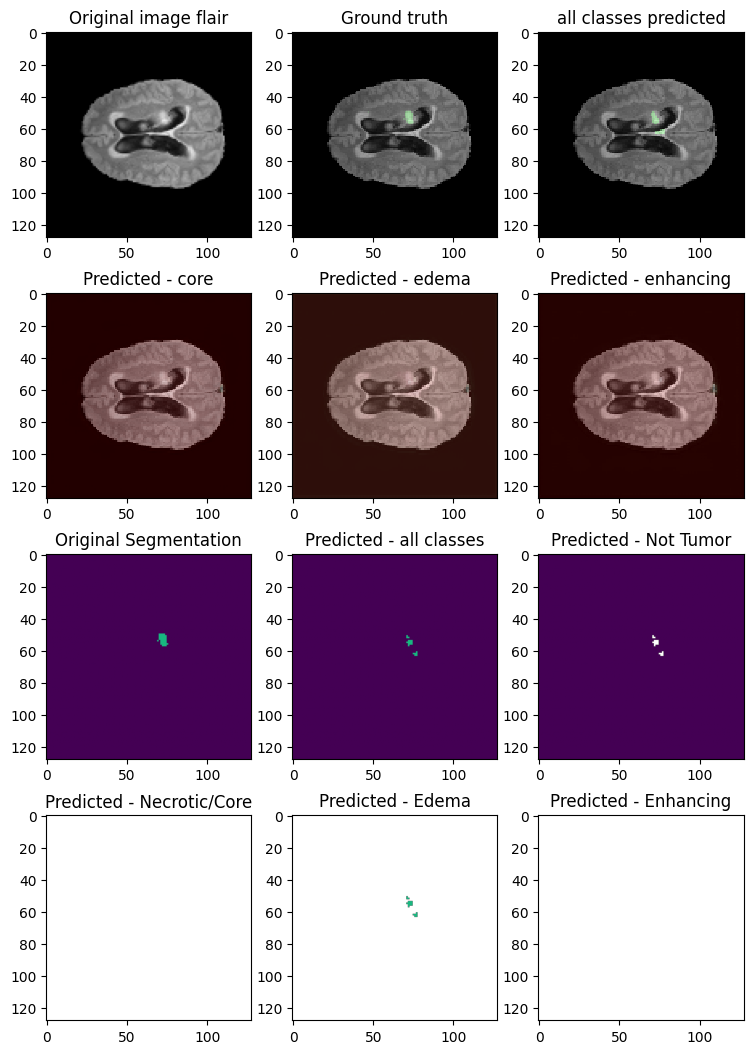

<Figure size 1000x1000 with 0 Axes>

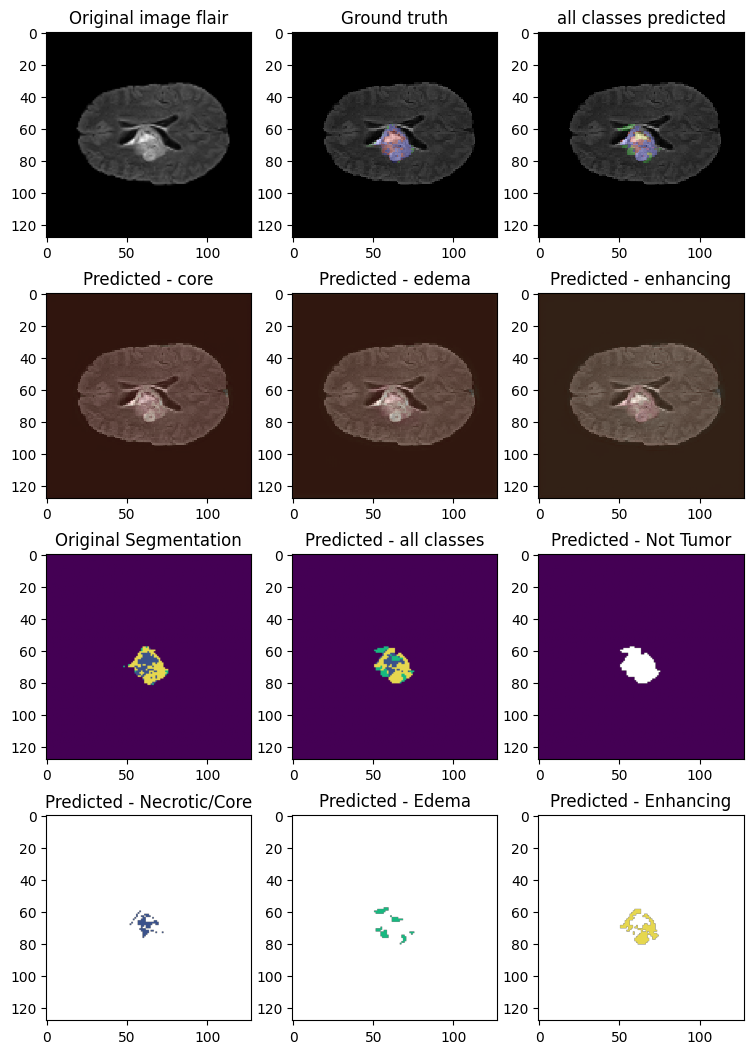

<Figure size 1000x1000 with 0 Axes>

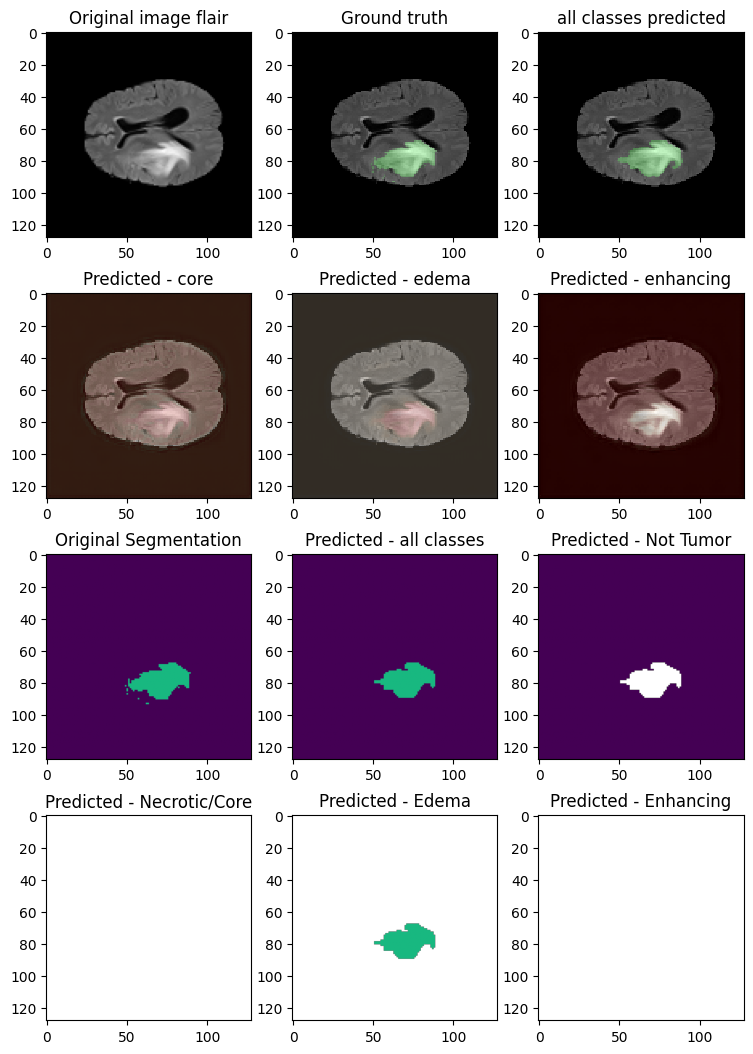

<Figure size 1000x1000 with 0 Axes>

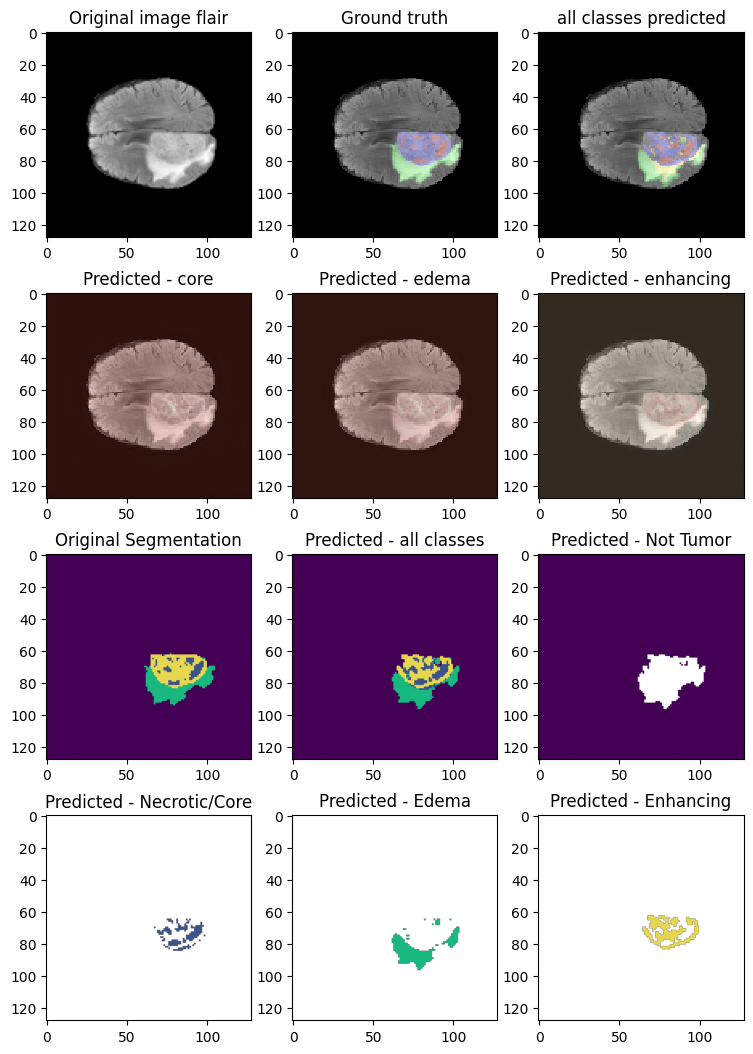

<Figure size 1000x1000 with 0 Axes>

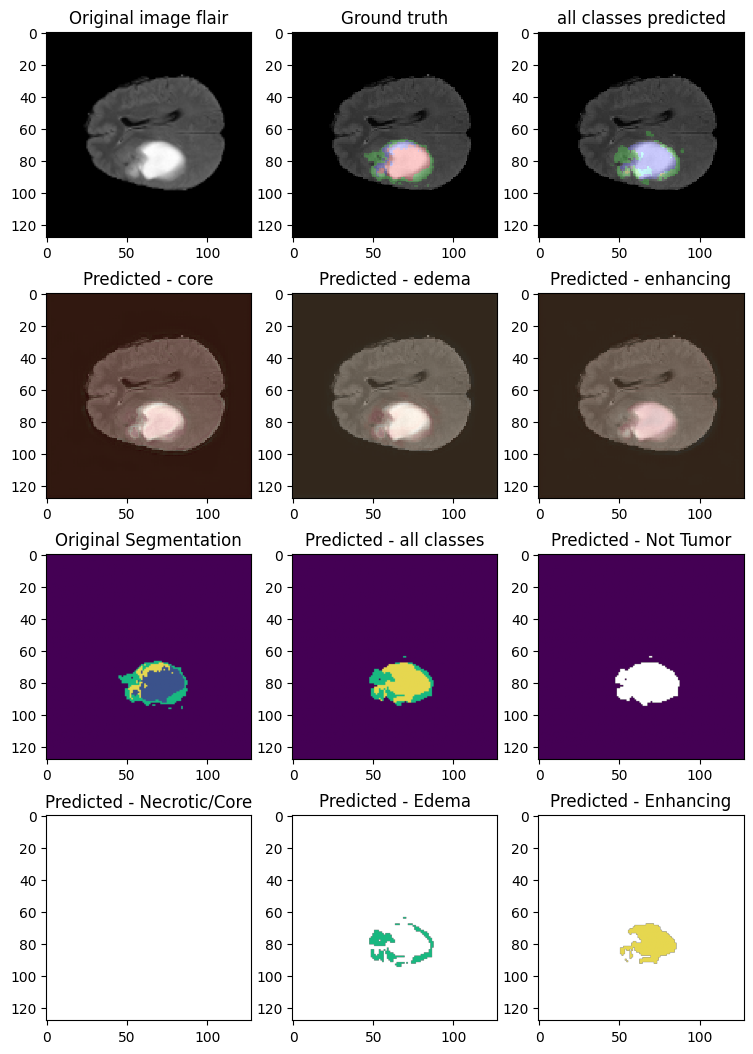

<Figure size 1000x1000 with 0 Axes>

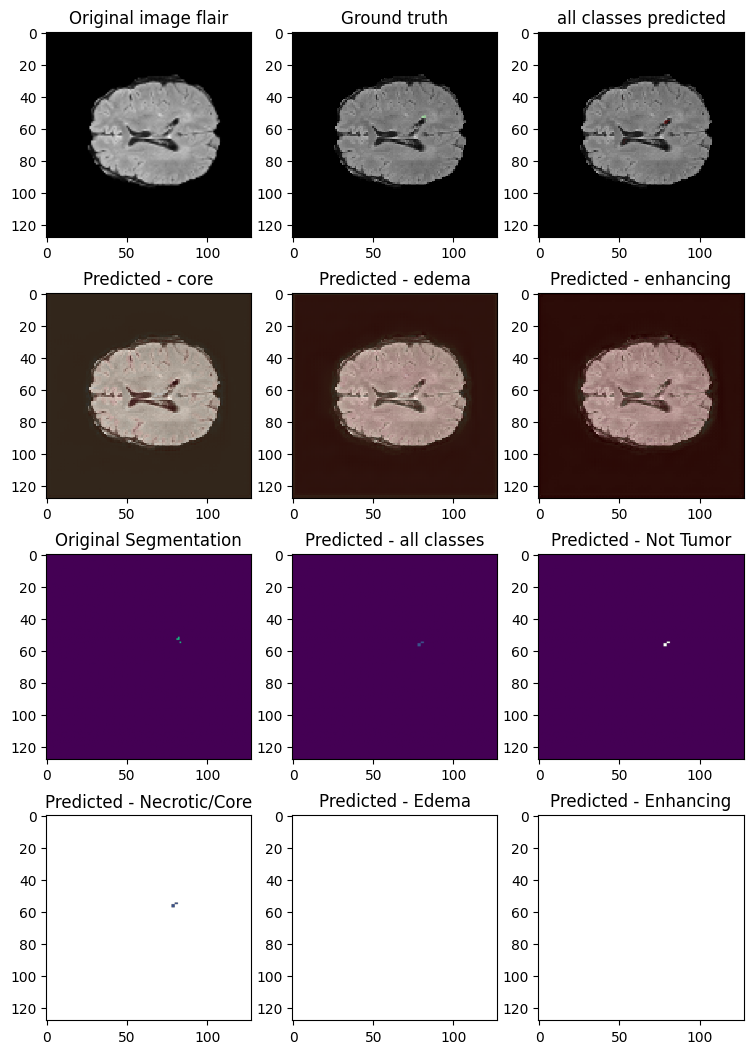

<Figure size 1000x1000 with 0 Axes>

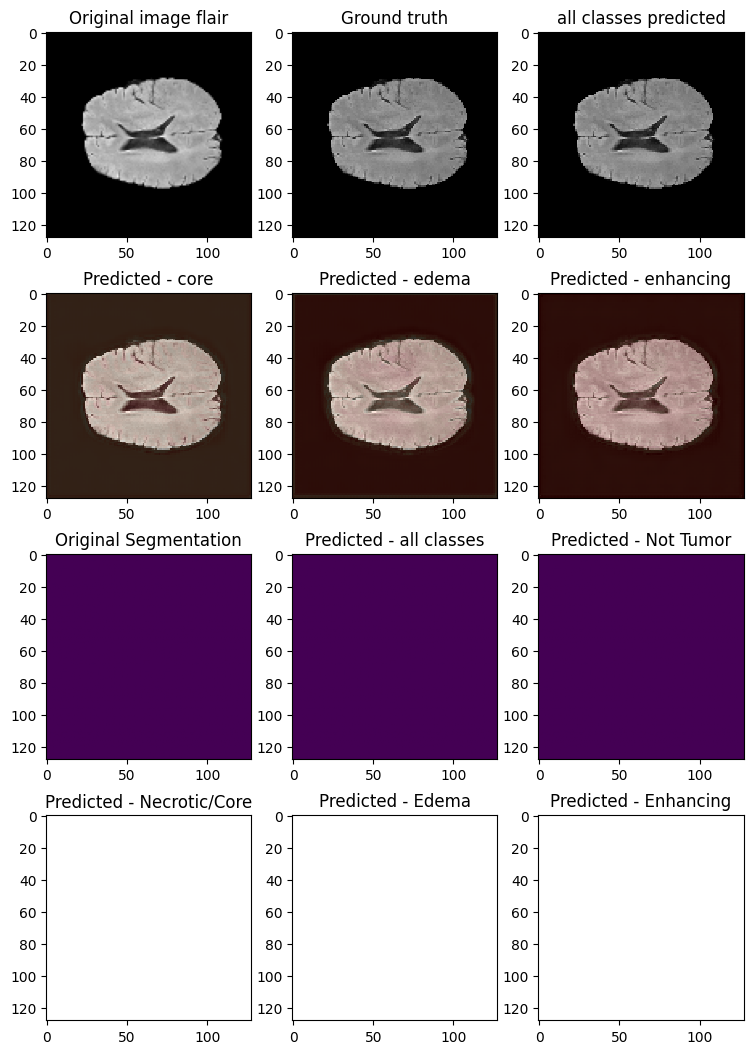

<Figure size 1000x1000 with 0 Axes>

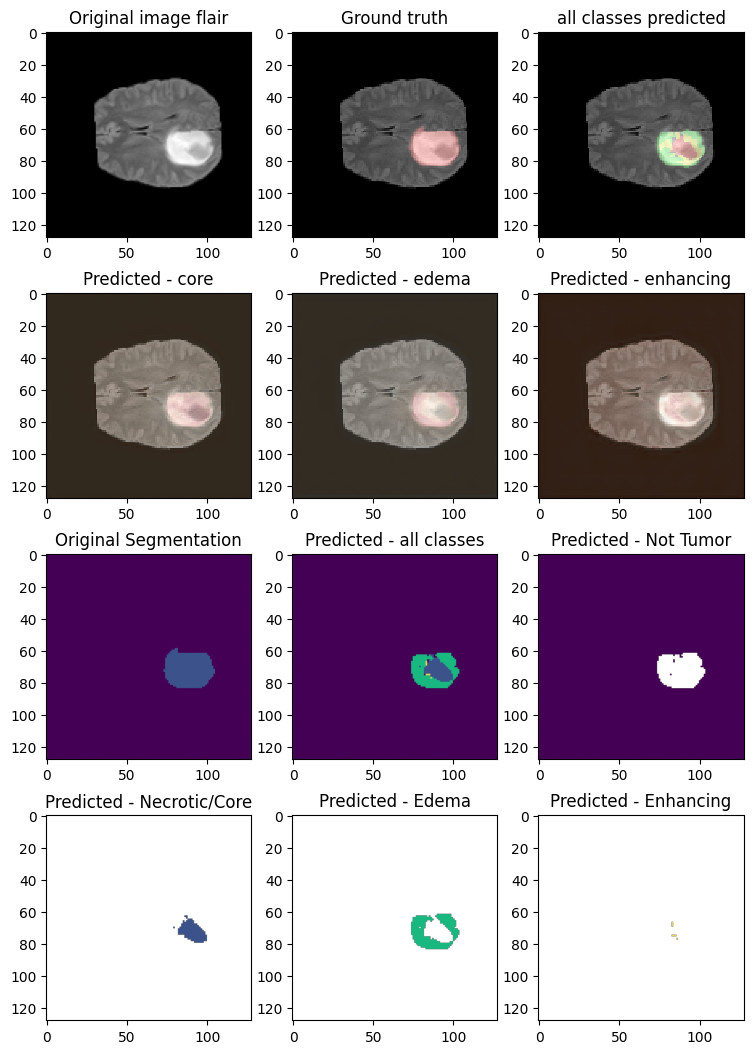

<Figure size 1000x1000 with 0 Axes>

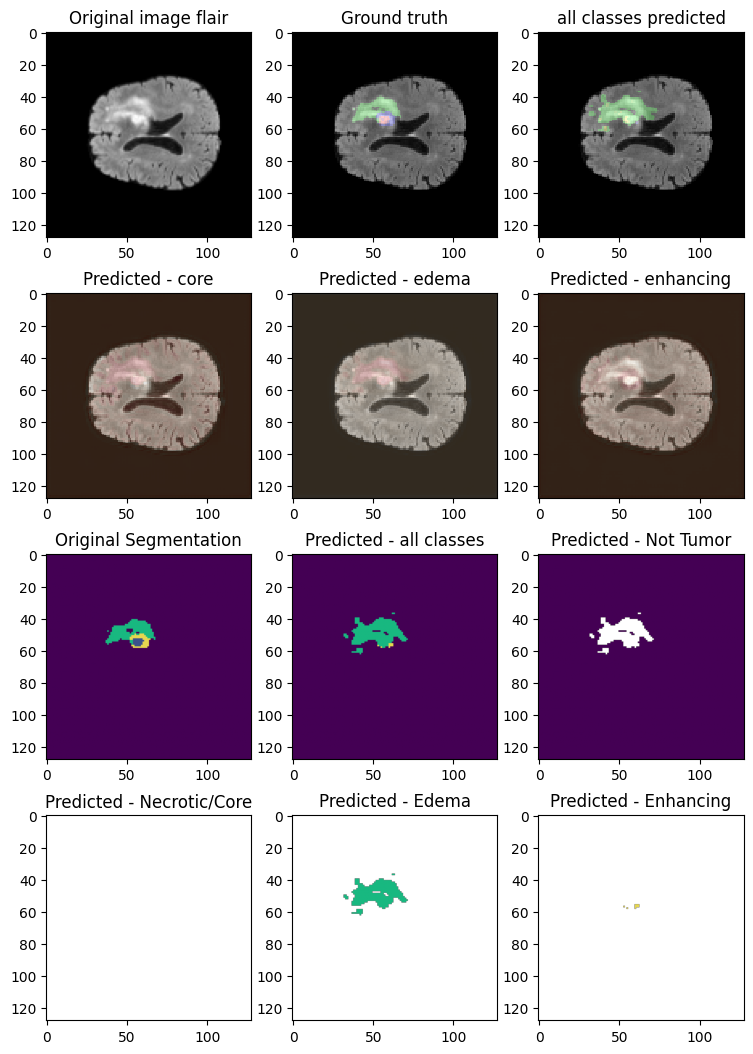

<Figure size 1000x1000 with 0 Axes>

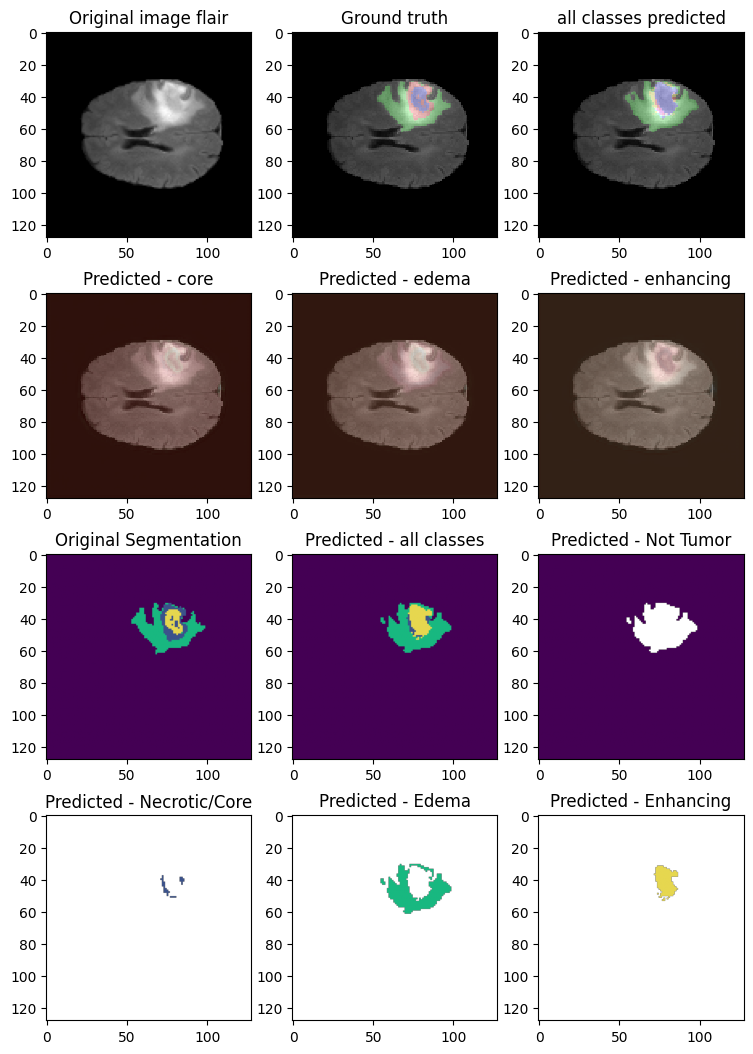

<Figure size 1000x1000 with 0 Axes>

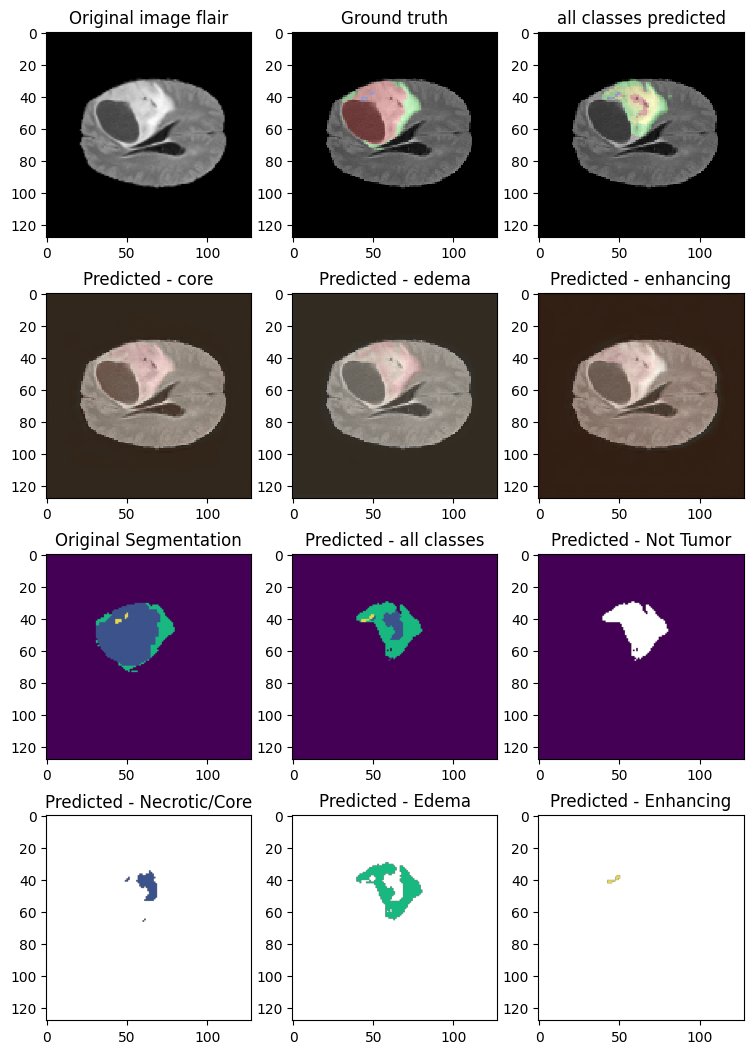

<Figure size 1000x1000 with 0 Axes>

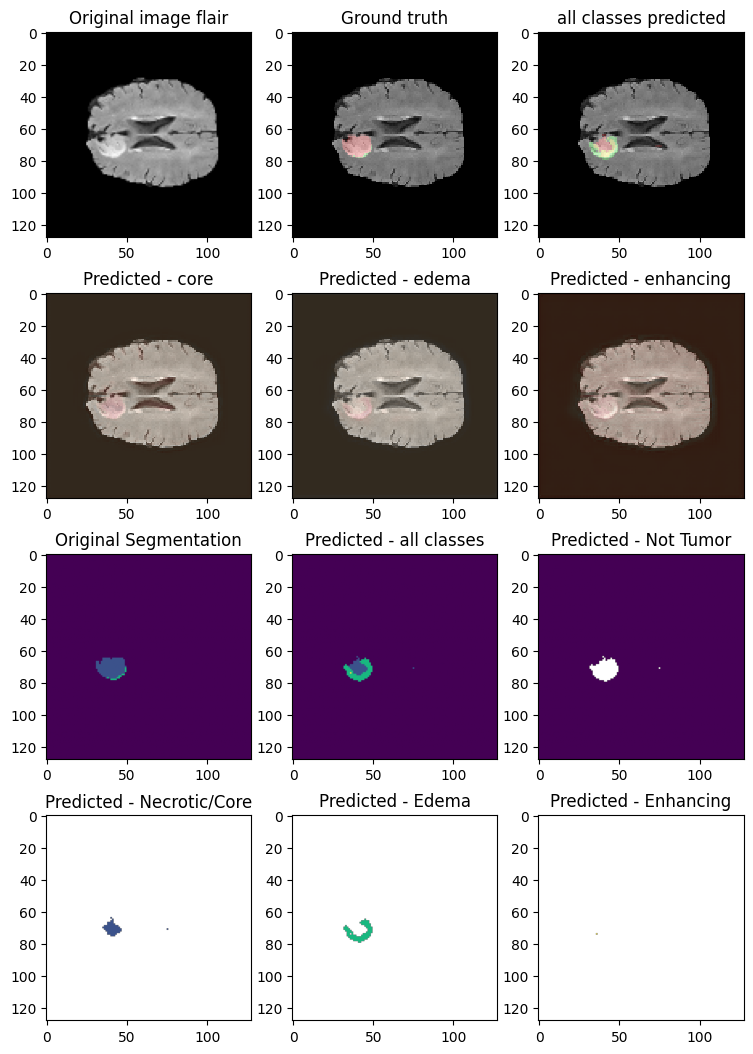

<Figure size 1000x1000 with 0 Axes>

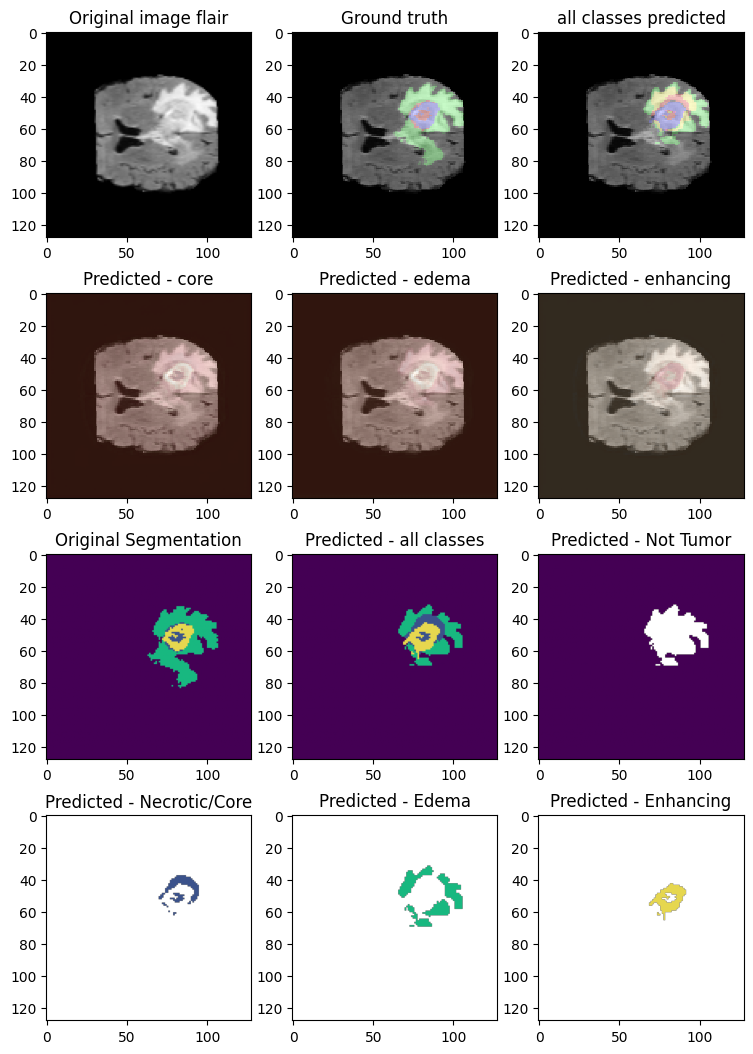

<Figure size 1000x1000 with 0 Axes>

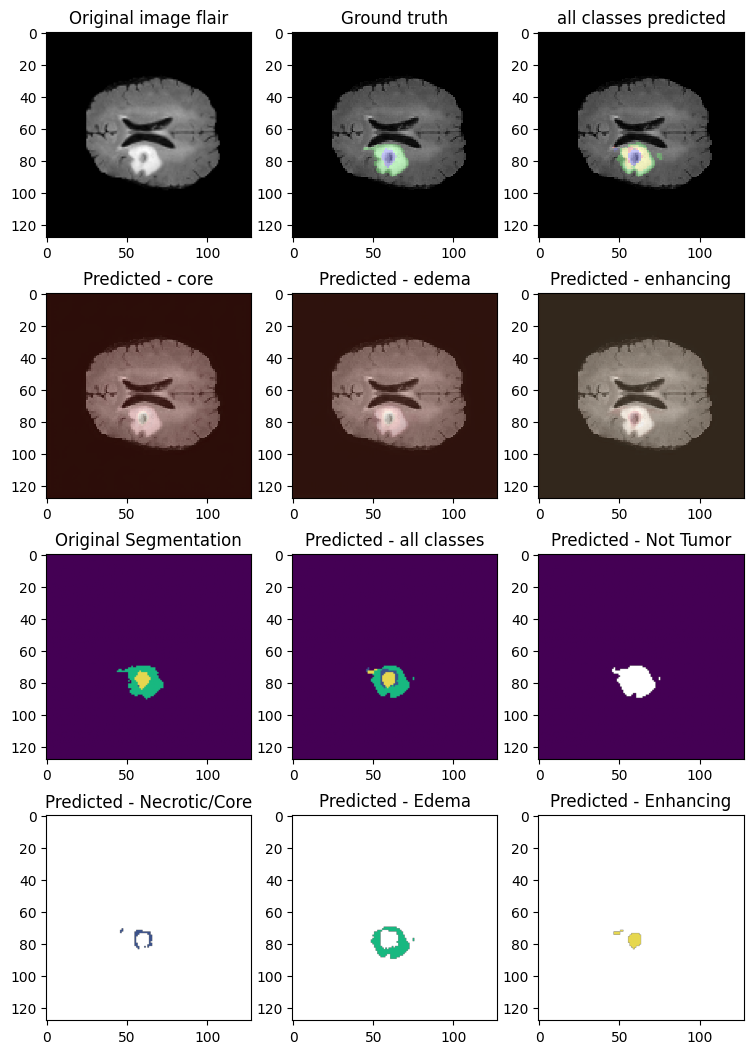

<Figure size 1000x1000 with 0 Axes>

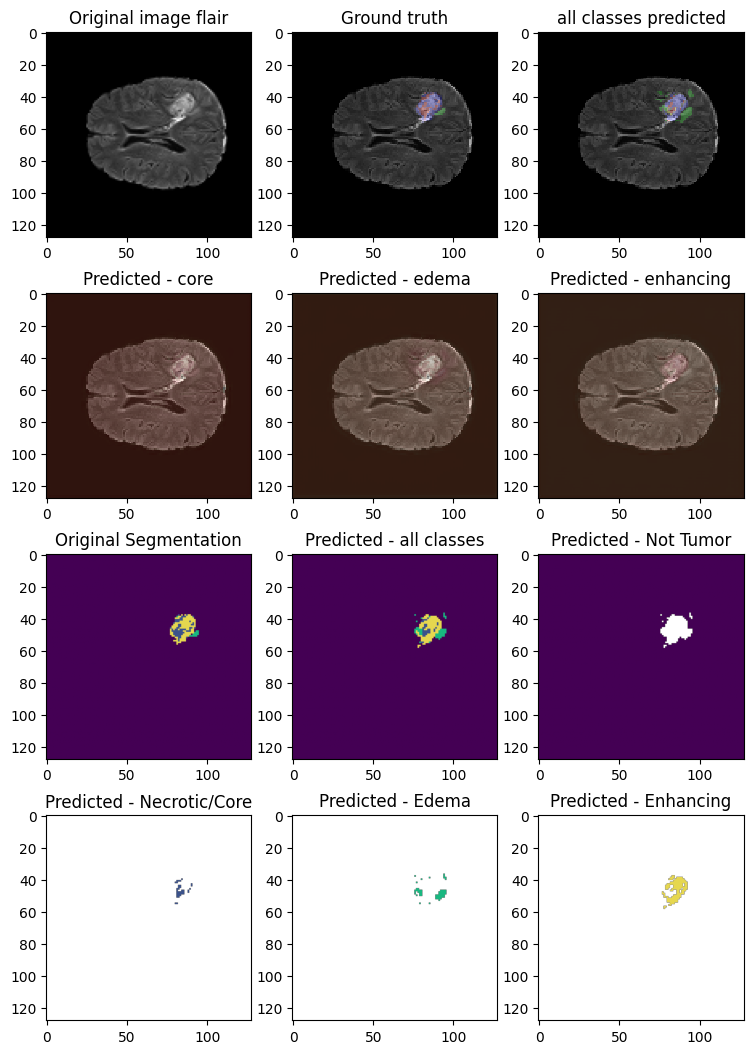

<Figure size 1000x1000 with 0 Axes>

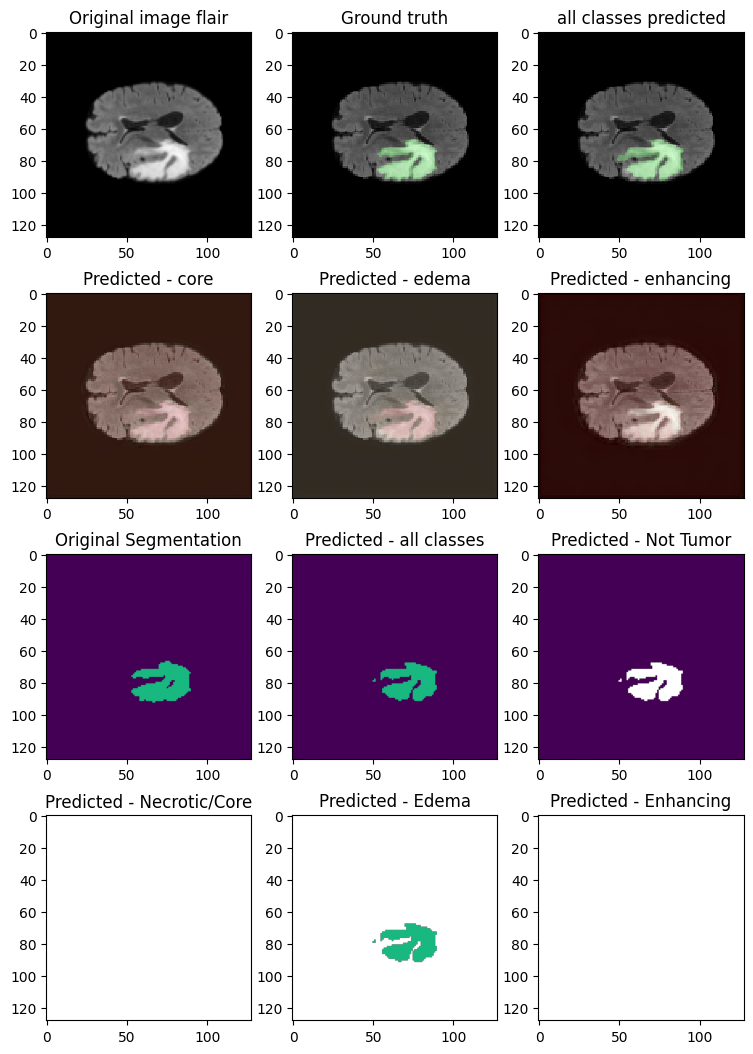

<Figure size 1000x1000 with 0 Axes>

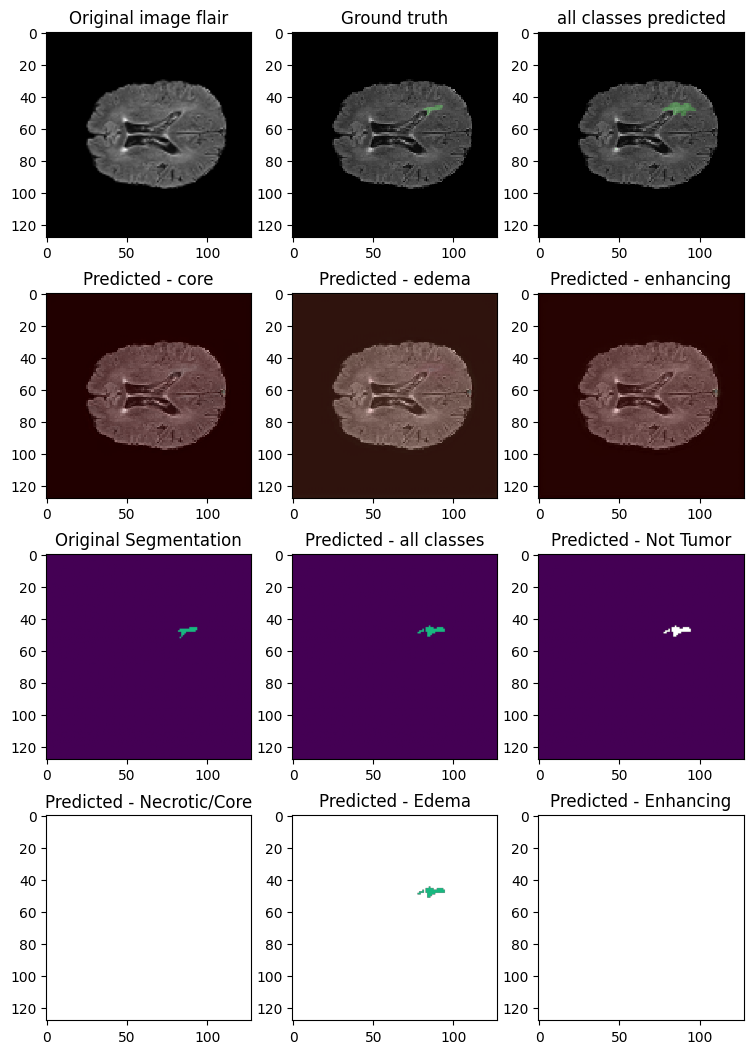

<Figure size 1000x1000 with 0 Axes>

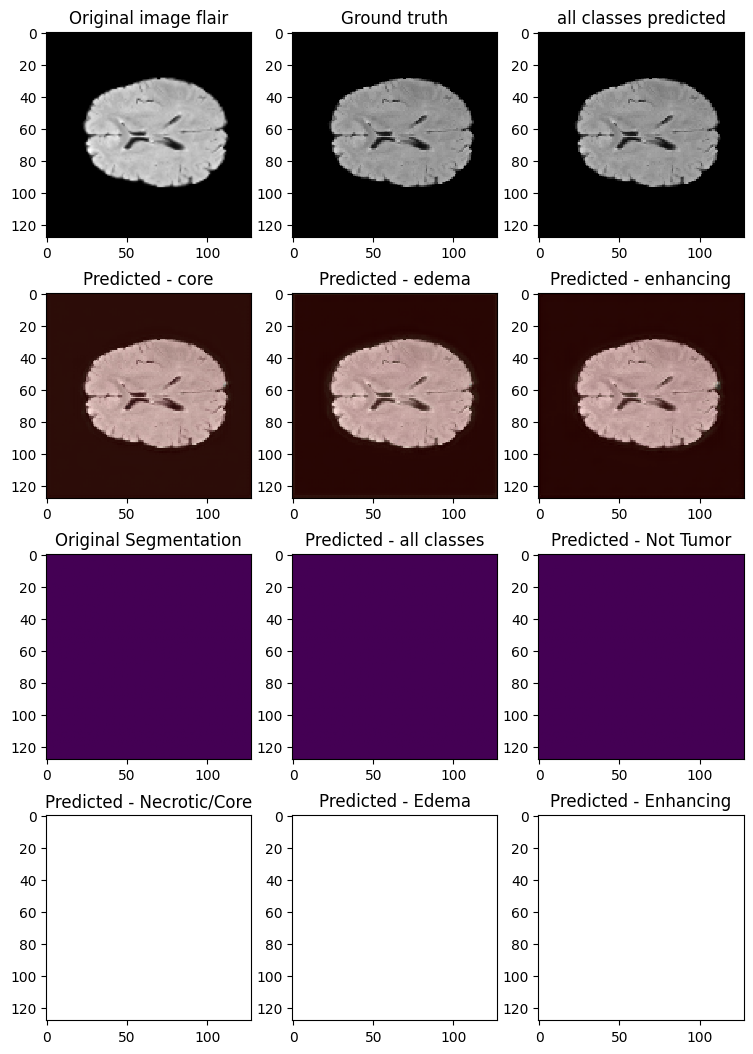

<Figure size 1000x1000 with 0 Axes>

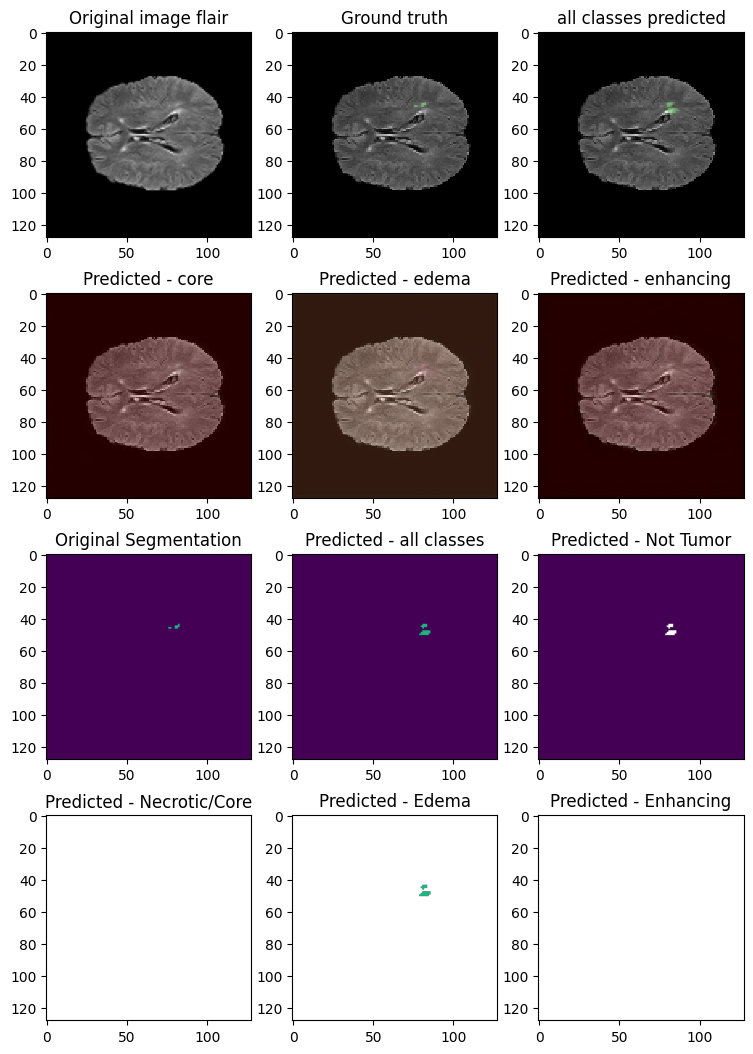

<Figure size 1000x1000 with 0 Axes>

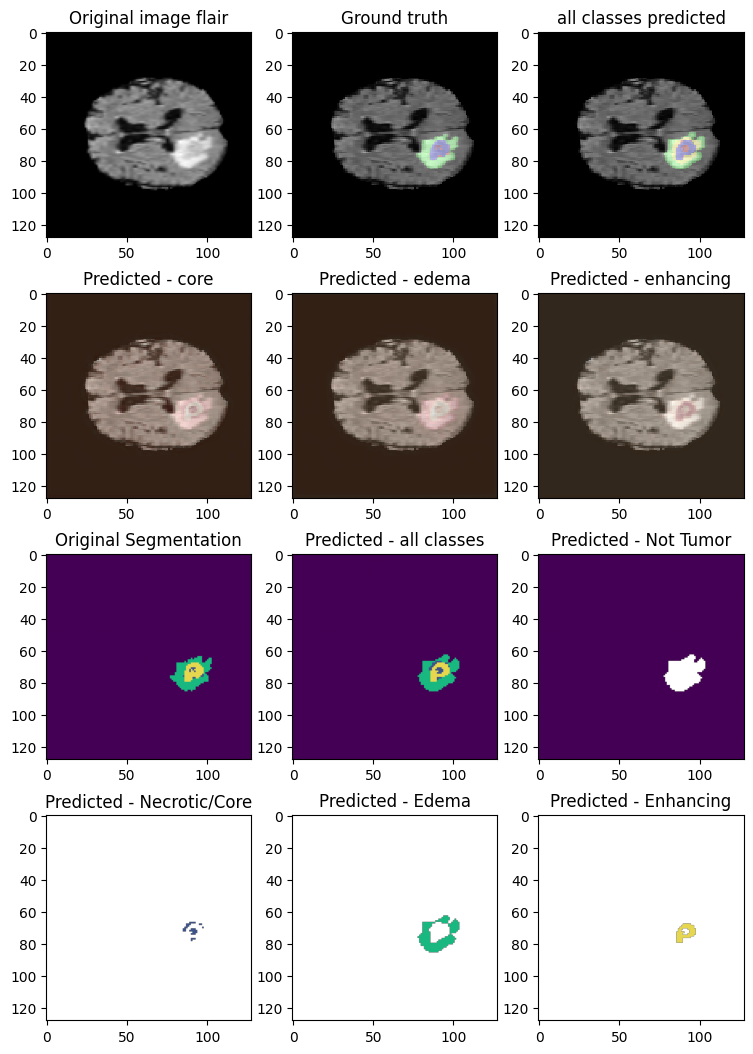

<Figure size 1000x1000 with 0 Axes>

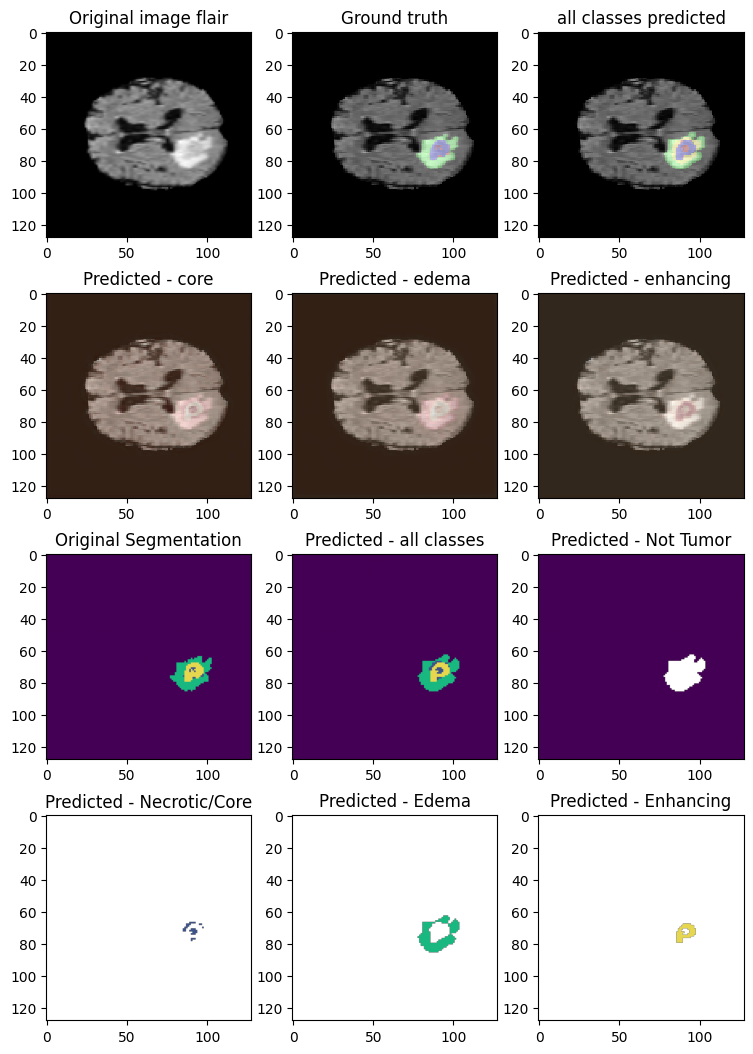

In [128]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = UNETR().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
if True:
  model_filename = "/content/drive/MyDrive/unetr/unter_weights.pth"
  checkpoint = torch.load(model_filename, map_location=DEVICE)
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

x, y = next(iter(test_loader))

cnt = 0

for i, (x, y) in enumerate(test_loader):
   Display_Tumor_Segmenstation(model, x, y, DEVICE)
   cnt+=1
   if cnt == 20:
     break



Display_Tumor_Segmenstation(model, x, y, DEVICE)

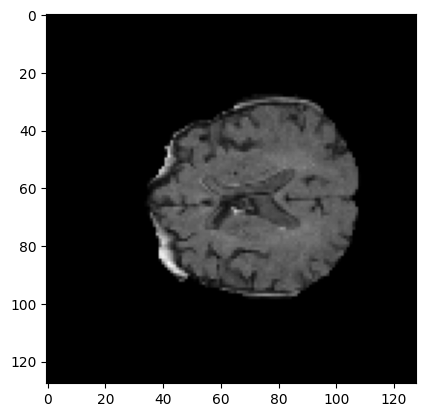

In [ ]:
# plt.imshow(x[75,:,:,0], cmap='gray')

In [ ]:
"""
x_.shape
x = x_.squeeze(dim=0)

print(x.shape)"""

torch.Size([96, 128, 128, 2])


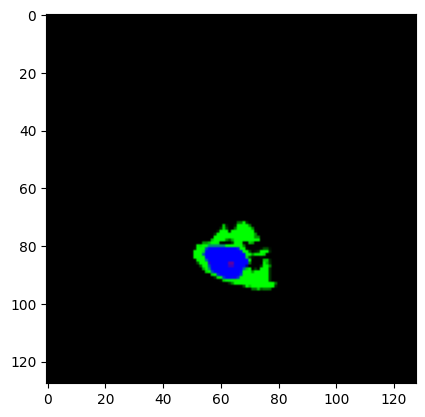

In [ ]:
# plt.imshow(y[50,:,:,1:4])

In [ ]:
# y = y_.squeeze(dim=0)
# y.shape

torch.Size([96, 128, 128, 4])

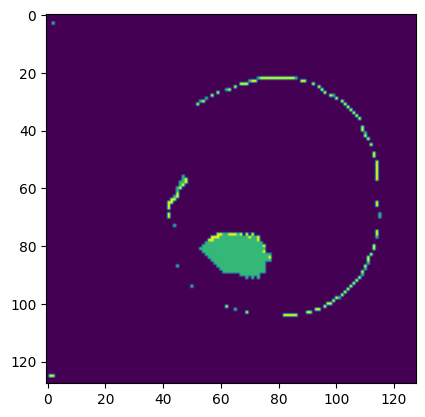

In [ ]:
# plt.imshow(p_seg[50])

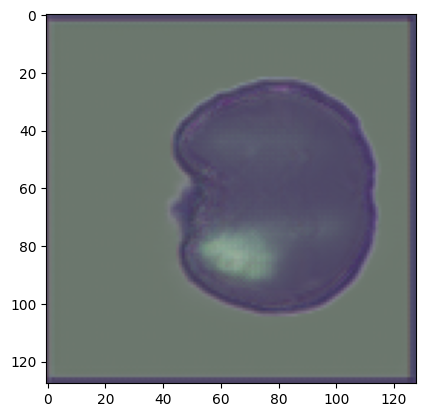

In [ ]:
# plt.imshow(p[50,:,:,1:4])

In [ ]:
"""
p = p.squeeze(dim=0)
p = p.permute(3, 1, 2, 0)

print(p.shape)
p_seg = torch.argmax(p, dim=-1)
print(p_seg.shape)"""

torch.Size([96, 128, 128, 4])
torch.Size([96, 128, 128])


In [ ]:
"""
model.eval()
with torch.no_grad():
  x = x_.permute(0, 4, 2, 3, 1).float()
  x = x.to(DEVICE)
  p = model(x).detach().cpu()
  p = torch.sigmoid(p)
"""
